# Trabajo Deep Learning

El objetivo de este proyecto es el de utilizar tres aproximaciones de redes neuronales para predecir el porcentaje de píxeles que contienen comida en imágenes de bandejas de comedores.

La primera aproximación usa redes sencillas que constan de dos o tres bloques de capas convolucionales.

La segunda aproximación utiliza la red pre-entrenada VGG16 añadiendo capas totalmente conectadas haciendo tanto transfer learning, como ne tuning. 

La tercera aproximación usa data augmentation para intentar obtener un mejor RMSE en los modelos que tenían overtting en las anteriores aproximaciones.

- [1. Modelo sencillo](#1_modelo_sencillo)
    - [1.1 Funciones](#1_1_funciones)
    - [1.2 Base](#1_2_base)
    - [1.3 Extra](#1_3_extra)
    - [1.4 Extra_filt](#1_4_extra_filt)
- [2. Modelo pre-entrenado](#2_modelo_preentrenado)
    - [2.1 Transfer learning](#2_1_transfer_learning) 
    - [2.2 Fine tuning](#2_2_fine_tuning)
- [3. Data augmentation](#3_data_augmentation)
    - [3.1 Modelo sencillo](#3_1_modelo_sencillo)
        - [3.1.1 Base](#3_1_1_base)
        - [3.1.2 Extra](#3_1_2_extra)
        - [3.1.3 Extra_filt](#3_1_3_extra_filt)
    - [3.2 Fine tuning](#3_2_fine_tuning)

<a id='1_modelo_sencillo'></a>
# 1. Modelo sencillo

Dentro de esta aproximación, se probarán tres arquitecturas:
- 2 bloques convolucionales con dos capas convolucionales cada uno, junto con una capa Max Pooling (modelo base),
- 3 bloques convolucionales con dos capas convolucionales cada uno, junto con una capa Max Pooling (modelo extra),
- 3 bloques convolucionales con dos capas convolucionales cada uno, junto con una capa Max Pooling, en donde el número de filtros de las capas va creciendo según se va avanzando en la red (modelo extra_filt)

Primero, importamos las librerías y clases necesarias a lo largo del notebook.

In [1]:
# Librerías generales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import csv
import os

# Clases para hacer la separación entrenamiento/test y para hacer la
# búsqueda de los hiperparámetros
from sklearn.model_selection import train_test_split

# Clases específicas para Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, GlobalMaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.python.framework.errors_impl import ResourceExhaustedError, InternalError
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K 


# Garbage collector
import gc

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
# Especificamos los paths al directorio que contiene las imagenes y al fichero con los porcentajes
data_path = './TrabajoDeepLearning/DL_UNIMIB2016/UNIMIB2016/'
imgs_path = data_path + "images/"
labels_path = data_path + "percentage.csv"

# Leemos el fichero CSV con los porcentajes
labels = pd.read_csv(labels_path)

# Creamos las tres particiones de datos: entrenamiento, validación y test
# 70% training, 15% validación  y 15% test
seed = 0 # para que los resultados puedan ser reproducibles
train_data, test_data = train_test_split(labels, test_size=0.3, random_state=seed)
dev_data, test_data = train_test_split(test_data, test_size=0.5, random_state=seed)

# Actualizamos los índices de cada particion
train_data = train_data.reset_index(drop=True)
dev_data = dev_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Preparamos los datos utilizando normalización (rescale)
datagen = ImageDataGenerator(rescale=1./255)

# dimensiones originales de las imágenes
img_width = 3264 
img_height = 2448  

# nombres de las columnas en el fichero CSV
x_col = 'image_name'     
y_col = 'food_pixels'

<a id='1_1_funciones'></a>
## 1.1 Funciones

Definimos una serie de funciones que se usarán para la creación y entrenamiento de las redes neuronales.

In [3]:
def plot_history(history, name_file=""):
    """
    Realiza un gráfico con el histórico de errores cuadráticos medios en cada epoch
    para la muestra de entrenamiento y la de validación.
    La imagen se guarda en name_file.
    """
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Error cuadrático medio')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='MSE en entrenamiento')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label='MSE en validación')
    plt.legend()
    
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    if name_file != "":
        fig1.savefig(name_file)


In [4]:
def create_model(Capas, Activations, Filtros, Tamanos, target_width, target_height):
    """
    Crea una red neuronal a partir de las listas con los hiperparámetros dada.
    """

    # Creamos un modelo secuencial, compuesto por una secuencia lineal de capas
    model = Sequential()

    # Se van añadiendo el resto de las capas según los valores de los parámetros
    # que se han pasado a la función
    for i in range(0, len(Capas)):
        if Capas[i] == "Conv":
            if i == 0:
                model.add(Conv2D(Filtros[i], Tamanos[i], activation=Activations[i], 
                         input_shape=(target_width,target_height,3),
                         kernel_initializer=initializers.he_normal())) 
            else:
                model.add(Conv2D(Filtros[i], Tamanos[i], activation=Activations[i], 
                         kernel_initializer=initializers.he_normal())) 
        elif Capas[i] == "Pool":
            model.add(MaxPooling2D(pool_size=(Tamanos[i],Tamanos[i])))
        elif Capas[i] == "Flatten":
            model.add(Flatten())
        elif Capas[i] == "Dense":
            model.add(Dense(Tamanos[i], activation=Activations[i], 
                        kernel_initializer=initializers.he_normal())) 
        elif Capas[i] == "Dropout":
            model.add(Dropout(Tamanos[i]))
    return model


In [5]:
class ModelClass:
    """
    Esta clase es una forma cómoda de poder definir diferentes estructuras de redes
    neuronales a partir de sus hiperparámetros.
    """

    loss = "mse" # Se usará esta función de pérdida al ser un problema de regresión

    def __init__(self, Capas=["Conv", "Conv", "Pool", "Conv", "Conv", "Pool", "Flatten", "Dense", "Dense"]
               , Activations=["relu", "relu", "", "relu", "relu", "", "", "relu", "relu"]
               , Filtros=[32,32,0,32,32,0,0,0,0]
               , Tamanos=[3,3,4,3,3,4,0,512,1]
               , LearnRate = 1e-5
               , Optimizer="Adam"
               , Batch=4
               , target_width = 400
               , target_height = 400):
        # Los valores por defecto se han encontrado al realizar varias pruebas y resultan en
        # un RMSE de cerca de 2.5 para la muestra de test

        self.Capas = Capas
        self.Activations = Activations
        self.Filtros = Filtros
        self.Tamanos = Tamanos
        self.LearnRate = LearnRate
        self.Optimizer = optimizers.Adam(lr=LearnRate)
        self.Batch = Batch

        # las imágenes son muy grandes, si las incluimos en el modelo tal cual, necesitaríamos
        # muchísima RAM. Por lo tanto, hay que reducir el tamaño
        self.target_width = target_width
        self.target_height = target_height

    def optim_upd(self,Optimizer):
        if Optimizer == "Adam":
            self.Optimizer = optimizers.Adam(lr=self.LearnRate)
        elif Optimizer == "SGD":
            self.Optimizer = optimizers.SGD(lr=self.LearnRate)

In [6]:
def gridSearch(model_arqs, max_epochs, patience, min_delta, train_data, imgs_path, x_col, y_col, prefix, datagen):
    
    # Estas listas almacenerán los resultados de cada una de las CNN
    histories = []
    test_losses = []
    times = []
    errors = []

    for model_arq in model_arqs:

        # Generamos los batches con los datos para las tres particiones
        batch_size = model_arq.Batch
        target_height = model_arq.target_height
        target_width = model_arq.target_width
        
        train_generator = datagen.flow_from_dataframe(dataframe=train_data, directory=imgs_path, x_col=x_col, y_col=y_col, 
                                                class_mode="raw", target_size=(target_width,target_height), batch_size=batch_size)
        dev_generator = datagen.flow_from_dataframe(dataframe=dev_data, directory=imgs_path, x_col=x_col, y_col=y_col,
                                                class_mode="raw", target_size=(target_width,target_height), batch_size=batch_size)
        test_generator = datagen.flow_from_dataframe(dataframe=test_data, directory=imgs_path, x_col=x_col, y_col=y_col,
                                                class_mode="raw", target_size=(target_width,target_height), batch_size=batch_size)

        # Imprimimos por pantalla el modelo
        print("Learning rate = " + str(model_arq.LearnRate))
        print("Optimizer = " + str(model_arq.Optimizer))
        print("Batch size = " + str(model_arq.Batch))
        print("Width = " + str(model_arq.target_width) + ", height = " + str(model_arq.target_height))
        
        
        try:
            for i in range(0,3): # probamos un máximo de 3 veces si no puede empezar a entrenar
                
                # Creamos el modelo
                model = create_model(model_arq.Capas, model_arq.Activations, model_arq.Filtros, model_arq.Tamanos, model_arq.target_width, model_arq.target_height)
                model.summary()
                model.compile(loss=model_arq.loss,
                              optimizer=model_arq.Optimizer 
                              )
                # Especificamos early stopping para evitar overfitting
                es = EarlyStopping(monitor='val_loss', mode='min', min_delta=min_delta, patience=patience, restore_best_weights=True)
                
                # Entrenamos el modelo
                start_time = time.time()
                results = model.fit_generator(train_generator,
                                epochs=max_epochs,  # número de epochs (puede ser grande ya que tenemos EarlyStopping)
                                verbose=2,  # muestra información del error al finalizar cada epoch
                                steps_per_epoch=int(len(train_data)/batch_size),
                                validation_data=dev_generator,
                                validation_steps=int(len(dev_data)/batch_size),
                                callbacks=[es])
                
                # Si se ha podido entrenar, no tenemos que probar más veces
                if results.history["loss"][-1]<200:
                    break
                    
            histories.append(results)
            
        # Errores que ocurren al no tener suficiente memoria en la GPU
        except ResourceExhaustedError:
            print("¡¡¡ Not enough available resources !!! (ResourceExhaustedError)")
            print(" Next iteration...")
            errors.append([model_arq.LearnRate, model_arq.Optimizer, model_arq.Batch, model_arq.target_width, model_arq.target_height])
            continue

        except InternalError:
            print("¡¡¡ Not enough available resources !!! (InternalError)")
            print(" Next iteration...")
            errors.append([model_arq.LearnRate, model_arq.Optimizer, model_arq.Batch, model_arq.target_width, model_arq.target_height])
            continue

        times.append(time.time() - start_time)
        print("Tiempo total transcurrido: " +str(times[len(times)-1]) + " seconds")

        # Evaluamos el modelo en el conjunto de test
        test_losses.append(model.evaluate_generator(test_generator,
                                            steps=int(len(test_data)/batch_size),
                                            verbose=1)
        )

        print("test_mse: " + str(test_losses[len(test_losses)-1]))
        print("test_rmse: " + str(np.sqrt(test_losses[len(test_losses)-1])))

        # Dibujamos la curva de entrenamiento para la muestra de entrenamiento y la de validación
        name_graph = str(prefix)+"_LR"+str(model_arq.LearnRate)+"_OPT"+str(model_arq.Optimizer)[len("keras.optimizers.")+1:str(model_arq.Optimizer).find(" ")]+"_BASZ"+str(model_arq.Batch)+"_WD"+str(model_arq.target_width)+".jpg"
        plot_history(histories[len(histories)-1], name_file=name_graph)

        for i in range(0,5):
            tf.reset_default_graph()
            try:
                del model
            except:
                pass
            K.clear_session()
            gc.collect()
        time.sleep(5) # dejamos 5 segundos para que se enfríe un poco la GPU y la CPU

    # Creamos un DataFrame que contenga un resumen de los resultados
    summ_results = pd.DataFrame(columns=['LearnRate', 'Optimizer', 'Batch', 'Width', 'Height', 'Train_loss', 'Val_loss', 'Test_loss', 'Time'])
    i=0
    j=0
    for model_arq in model_arqs:
        # si ha habido errores en el entrenamiento, se pone -1 en sus resultados
        if errors==[]:
            trainLoss = histories[i].history["loss"][-1-patience]
            valLoss = histories[i].history["val_loss"][-1-patience]
            testLoss = test_losses[i]
            trainTime = times[i]
        else:
            for error in errors:
                if (( (model_arq.LearnRate == error[0]) & (str(model_arq.Optimizer) == str(error[1])) & (model_arq.Batch == error[2]) & (model_arq.target_width == error[3]) & (model_arq.target_height == error[4])) |  len(histories)<= i ):
                    trainLoss = -1
                    valLoss = -1
                    testLoss = -1
                    trainTime = -1
                    i = i-1
                    break
                else:
                    trainLoss = histories[i].history["loss"][-1-patience]
                    valLoss = histories[i].history["val_loss"][-1-patience]
                    testLoss = test_losses[i]
                    trainTime = times[i]
        i = i+1
        tmp = pd.DataFrame(data={'LearnRate': str(model_arq.LearnRate), 'Optimizer': str(model_arq.Optimizer), 'Batch': str(model_arq.Batch), 
                               'Width': str(model_arq.target_width), 'Height': str(model_arq.target_height), 'Train_loss' : trainLoss,
                               'Val_loss' : valLoss, 'Test_loss': testLoss, 'Time' : trainTime }, index=[j])
        summ_results = pd.concat([summ_results, tmp])
        j=j+1
        
    return summ_results, histories, test_losses, times, errors

Se hace un grid search sobre varios hiper-parámetros. Al correr el entrenamiento en un notebook, es más complicado liberar memoria de la GPU con tensorflow, por lo que el grid search es limitado.

In [7]:
LearnRates = [1e-1, 1e-2, 1e-3]
Optimizers = ["Adam","SGD"]
Batches = [4,8,16] 
Sizes = [[int(img_width/i), int(img_height/i)] for i in [6,9]]

max_epochs = 200
patience = 5
min_delta = 0.1

Se definen todos los modelos que se van a probar. No se pueden correr las tres arquitecturas en la misma celda del notebook por no poder liberar espacio de la GPU correctamente.

<a id='1_2_base'></a>
## 1.2 Base
Se empieza con la arquitectura base, en donde hay dos bloques convolucionales iguales.

In [8]:
model_arqs_base = []
# Arquitectura base
for learnRate in LearnRates:
    for optimizer in Optimizers:
        for size in Sizes:
            for batch in Batches:
                model_arq = ModelClass()
                model_arq.Batch = batch
                model_arq.optim_upd(optimizer)
                model_arq.target_width = size[0]
                model_arq.target_height = size[1]
                model_arq.LearnRate = learnRate
                model_arqs_base.append(model_arq)

Se entrena el modelo con los diferentes hiper-parámetros.

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc49893ceb8>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248   

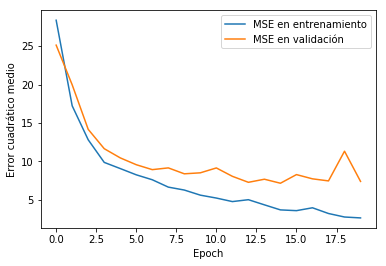

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc498990518>
Batch size = 8
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248   

<Figure size 432x288 with 0 Axes>

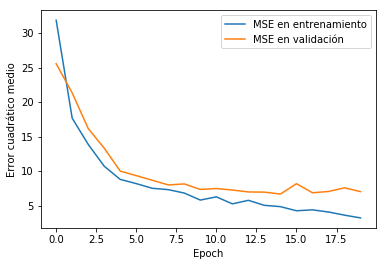

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc4989906d8>
Batch size = 16
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248  

<Figure size 432x288 with 0 Axes>

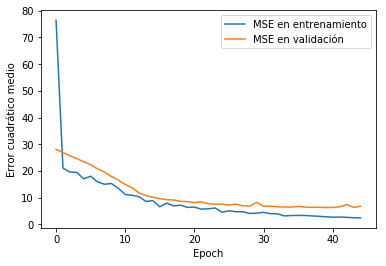

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc4989906a0>
Batch size = 4
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)        9248   

<Figure size 432x288 with 0 Axes>

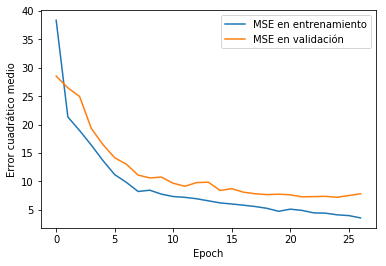

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc4989904e0>
Batch size = 8
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)        9248   

<Figure size 432x288 with 0 Axes>

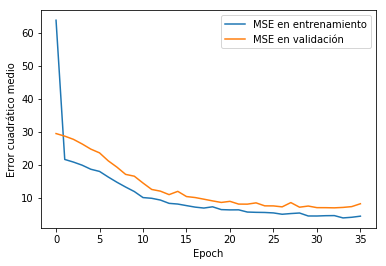

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc498990780>
Batch size = 16
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)        9248  

<Figure size 432x288 with 0 Axes>

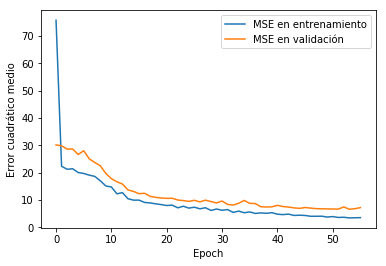

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fc498990f98>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)   

<Figure size 432x288 with 0 Axes>

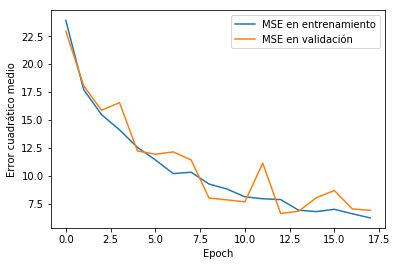

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fc498990e48>
Batch size = 8
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)   

<Figure size 432x288 with 0 Axes>

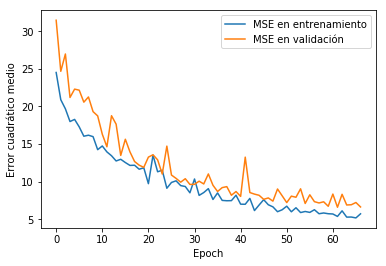

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fc498990b00>
Batch size = 16
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)  

<Figure size 432x288 with 0 Axes>

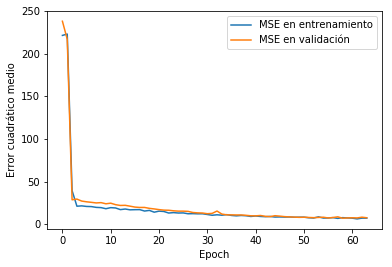

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fc498990358>
Batch size = 4
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)    

<Figure size 432x288 with 0 Axes>

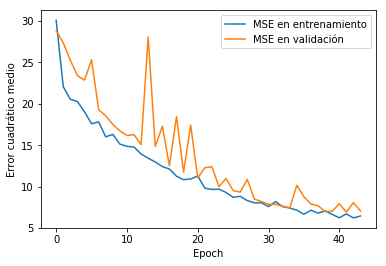

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fc498990438>
Batch size = 8
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)    

<Figure size 432x288 with 0 Axes>

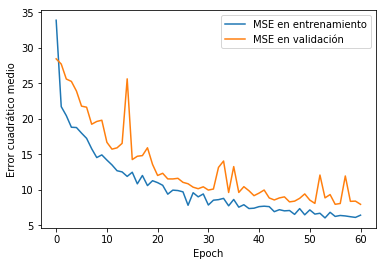

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fc498990ac8>
Batch size = 16
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)   

<Figure size 432x288 with 0 Axes>

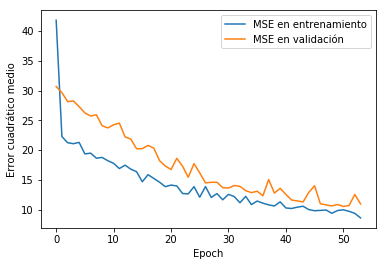

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc498990c18>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248  

<Figure size 432x288 with 0 Axes>

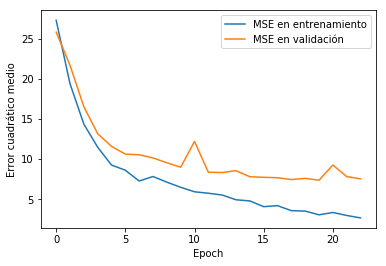

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc4989e9748>
Batch size = 8
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248  

<Figure size 432x288 with 0 Axes>

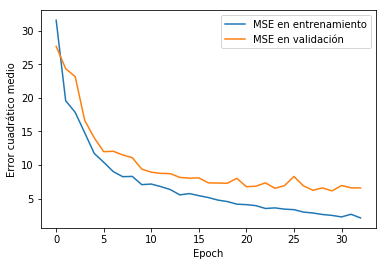

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc4989e9a90>
Batch size = 16
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248 

<Figure size 432x288 with 0 Axes>

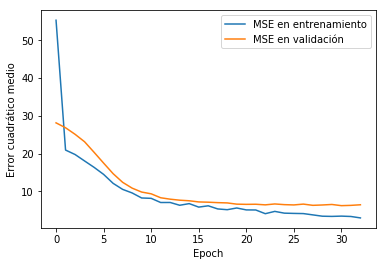

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc4989e9b00>
Batch size = 4
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)        9248  

<Figure size 432x288 with 0 Axes>

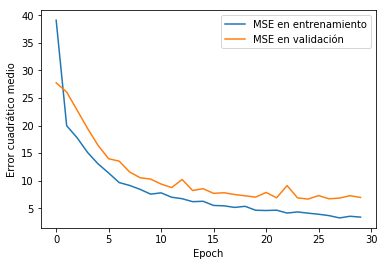

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc4989e9f98>
Batch size = 8
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)        9248  

<Figure size 432x288 with 0 Axes>

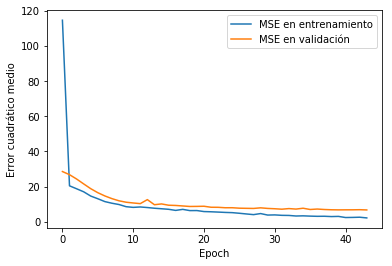

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc4989e9eb8>
Batch size = 16
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)        9248 

<Figure size 432x288 with 0 Axes>

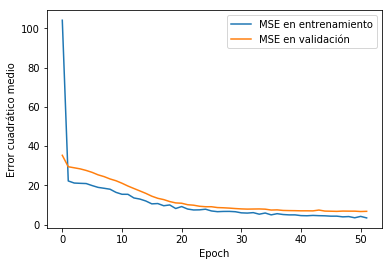

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fc4989e9cc0>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)  

<Figure size 432x288 with 0 Axes>

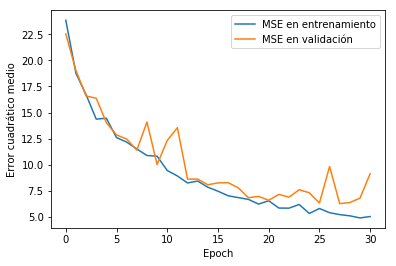

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fc4989e9978>
Batch size = 8
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)  

<Figure size 432x288 with 0 Axes>

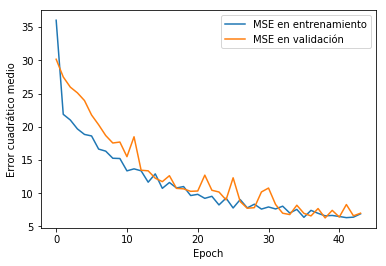

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fc4989e99e8>
Batch size = 16
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32) 

<Figure size 432x288 with 0 Axes>

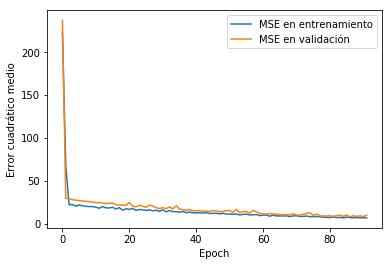

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fc51c5a7a58>
Batch size = 4
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)   

<Figure size 432x288 with 0 Axes>

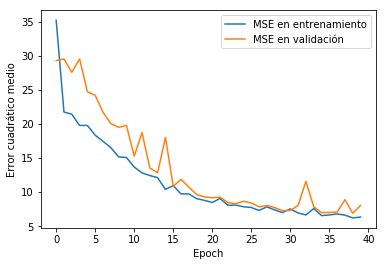

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fc51c5a79e8>
Batch size = 8
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)   

<Figure size 432x288 with 0 Axes>

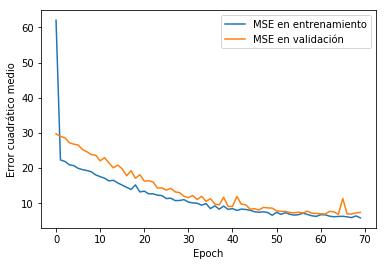

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fc51c5a7da0>
Batch size = 16
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)  

<Figure size 432x288 with 0 Axes>

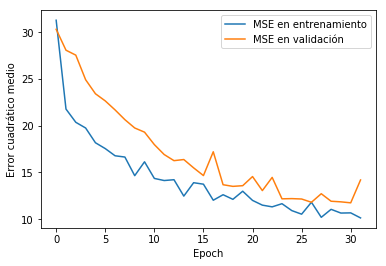

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc51c5a7f28>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248 

<Figure size 432x288 with 0 Axes>

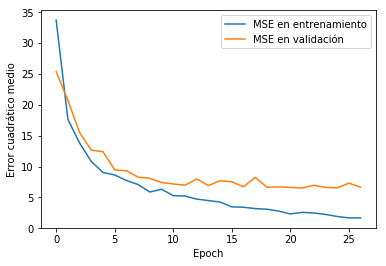

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc51c5a7c18>
Batch size = 8
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248 

<Figure size 432x288 with 0 Axes>

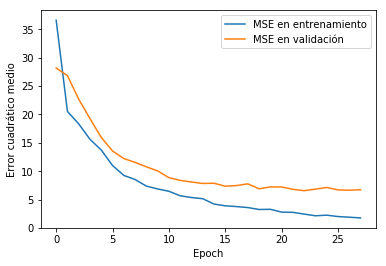

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc51c5a7940>
Batch size = 16
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248

<Figure size 432x288 with 0 Axes>

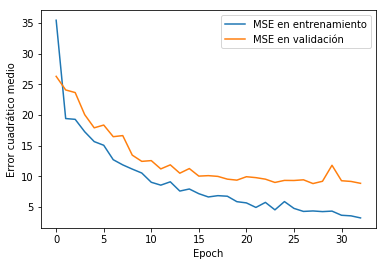

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc51c5a7dd8>
Batch size = 4
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)        9248 

<Figure size 432x288 with 0 Axes>

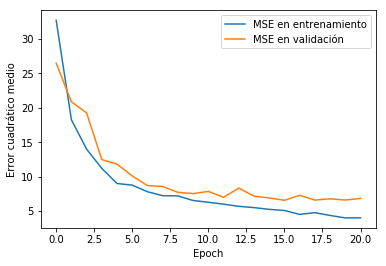

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc51c5a7cc0>
Batch size = 8
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)        9248 

<Figure size 432x288 with 0 Axes>

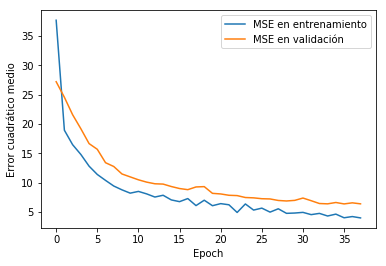

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc498942208>
Batch size = 16
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)        9248

<Figure size 432x288 with 0 Axes>

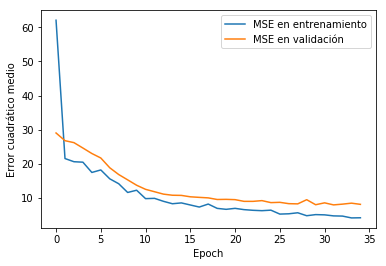

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fc4989422e8>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32) 

<Figure size 432x288 with 0 Axes>

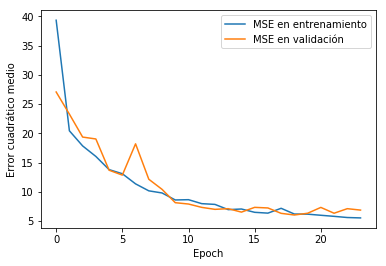

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fc4989423c8>
Batch size = 8
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32) 

<Figure size 432x288 with 0 Axes>

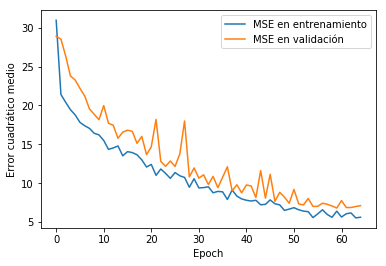

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fc4989424e0>
Batch size = 16
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)

<Figure size 432x288 with 0 Axes>

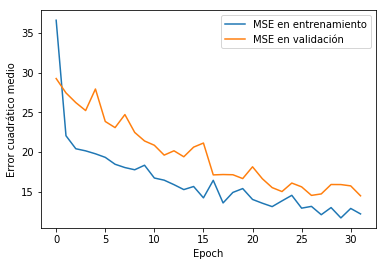

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fc4989425f8>
Batch size = 4
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)  

<Figure size 432x288 with 0 Axes>

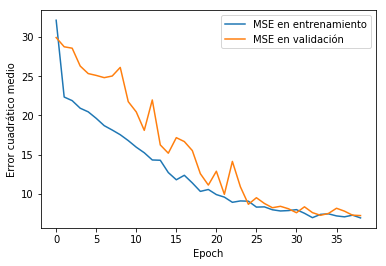

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fc498942710>
Batch size = 8
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)  

<Figure size 432x288 with 0 Axes>

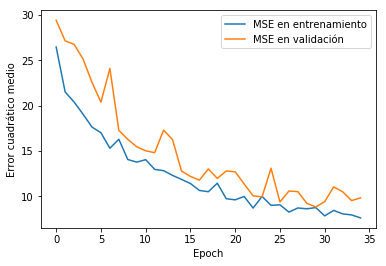

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fc498942828>
Batch size = 16
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32) 

Epoch 76/200
44/44 - 4s - loss: 8.1877 - val_loss: 8.6942
Epoch 77/200
44/44 - 4s - loss: 7.5810 - val_loss: 8.6584
Epoch 78/200
44/44 - 4s - loss: 7.6934 - val_loss: 8.2738
Epoch 79/200
44/44 - 4s - loss: 7.7234 - val_loss: 8.2165
Epoch 80/200
44/44 - 4s - loss: 7.1264 - val_loss: 8.1773
Epoch 81/200
44/44 - 4s - loss: 7.3822 - val_loss: 8.3053
Epoch 82/200
44/44 - 4s - loss: 7.7419 - val_loss: 8.1048
Epoch 83/200
44/44 - 4s - loss: 7.2922 - val_loss: 8.7963
Epoch 84/200
44/44 - 4s - loss: 7.0968 - val_loss: 8.0192
Epoch 85/200
44/44 - 4s - loss: 7.1574 - val_loss: 7.7714
Epoch 86/200
44/44 - 4s - loss: 7.5094 - val_loss: 7.9106
Epoch 87/200
44/44 - 4s - loss: 7.0553 - val_loss: 7.8417
Epoch 88/200
44/44 - 4s - loss: 6.7139 - val_loss: 7.6165
Epoch 89/200
44/44 - 4s - loss: 6.9601 - val_loss: 7.8768
Epoch 90/200
44/44 - 4s - loss: 6.9502 - val_loss: 7.7567
Epoch 91/200
44/44 - 4s - loss: 7.0941 - val_loss: 8.2004
Epoch 92/200
44/44 - 5s - loss: 6.7276 - val_loss: 7.9722
Epoch 93/200
4

<Figure size 432x288 with 0 Axes>

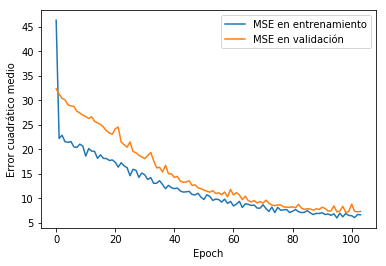

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



<Figure size 432x288 with 0 Axes>

In [9]:
summ_results_base, histories_base, test_losses_base, times_base, errors_base = gridSearch(model_arqs_base, max_epochs, patience, min_delta, train_data, imgs_path, x_col, y_col, "Base", datagen)
summ_results_base["Arq"] = "Base"

# Guardamos los resultados
summ_results_base.to_csv("summ_results_base.csv", index=False)

<a id='1_3_extra'></a>
## 1.3 Extra

Se sigue con la arquitectura donde hay un bloque "extra" en comparación a la arquitectura "base", es decir, hay tres bloques convolucionales iguales.

In [8]:
model_arqs_extra = []
# Añadiendo un bloque Conv+Conv+Pool a la arquitectura base
for learnRate in LearnRates:
    for optimizer in Optimizers:
        for size in Sizes:
            for batch in Batches:
                model_arq = ModelClass()

                model_arq.Capas=["Conv", "Conv", "Pool", "Conv", "Conv", "Pool", "Conv", "Conv", "Pool", "Flatten", "Dense", "Dense"]
                model_arq.Activations=["relu", "relu", "", "relu", "relu", "", "relu", "relu", "", "", "relu", "relu"]
                model_arq.Filtros=[32,32,0,32,32,0,32,32,0,0,0,0]
                model_arq.Tamanos=[3,3,4,3,3,4,3,3,4,0,512,1]

                model_arq.Batch = batch
                model_arq.optim_upd(optimizer)
                model_arq.target_width = size[0]
                model_arq.target_height = size[1]
                model_arq.LearnRate = learnRate
                model_arqs_extra.append(model_arq)

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f82122713c8>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248   

Epoch 62/200
179/179 - 9s - loss: 3.9219 - val_loss: 6.4620
Epoch 63/200
179/179 - 9s - loss: 3.5403 - val_loss: 6.4426
Epoch 64/200
179/179 - 9s - loss: 3.3883 - val_loss: 6.5318
Epoch 65/200
179/179 - 9s - loss: 3.9172 - val_loss: 6.3734
Tiempo total transcurrido: 586.4491498470306 seconds
38/38 [==============================] - 1s 28ms/step - loss: 4.9839
test_mse: 4.983910883727827
test_rmse: 2.2324674429267333


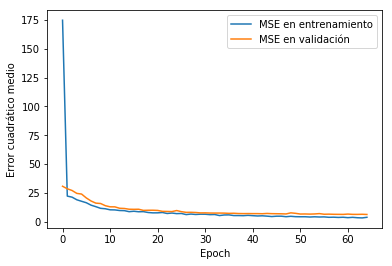

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f81e6e3cb00>
Batch size = 8
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248   

<Figure size 432x288 with 0 Axes>

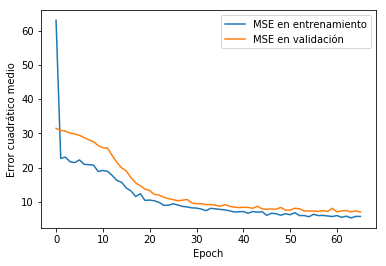

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f81e6e3cef0>
Batch size = 16
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248  

44/44 - 7s - loss: 11.2257 - val_loss: 14.6297
Epoch 25/200
44/44 - 7s - loss: 11.0754 - val_loss: 14.0881
Epoch 26/200
44/44 - 7s - loss: 10.5825 - val_loss: 13.6559
Epoch 27/200
44/44 - 7s - loss: 9.5714 - val_loss: 13.3429
Epoch 28/200
44/44 - 8s - loss: 10.0406 - val_loss: 13.3639
Epoch 29/200
44/44 - 7s - loss: 10.2499 - val_loss: 12.9628
Epoch 30/200
44/44 - 8s - loss: 9.0020 - val_loss: 12.4723
Epoch 31/200
44/44 - 7s - loss: 9.9511 - val_loss: 12.0418
Epoch 32/200
44/44 - 7s - loss: 8.9761 - val_loss: 11.7834
Epoch 33/200
44/44 - 7s - loss: 8.9750 - val_loss: 12.1269
Epoch 34/200
44/44 - 7s - loss: 8.8289 - val_loss: 12.5629
Epoch 35/200
44/44 - 8s - loss: 7.9833 - val_loss: 11.3249
Epoch 36/200
44/44 - 7s - loss: 9.2526 - val_loss: 11.0273
Epoch 37/200
44/44 - 8s - loss: 8.4549 - val_loss: 11.3492
Epoch 38/200
44/44 - 7s - loss: 8.0326 - val_loss: 10.7632
Epoch 39/200
44/44 - 7s - loss: 8.5709 - val_loss: 10.5820
Epoch 40/200
44/44 - 7s - loss: 7.9059 - val_loss: 10.6392
Epoch

<Figure size 432x288 with 0 Axes>

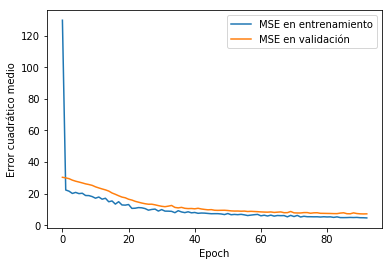

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f81e6e3cf28>
Batch size = 4
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)        9248   

<Figure size 432x288 with 0 Axes>

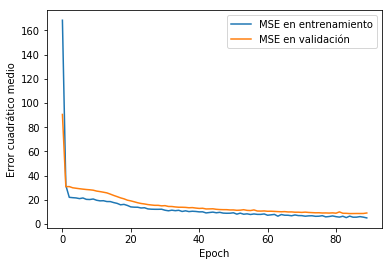

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f82691fc828>
Batch size = 8
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)        9248   

Epoch 102/200
89/89 - 5s - loss: 7.5250 - val_loss: 11.1311
Epoch 103/200
89/89 - 5s - loss: 6.6183 - val_loss: 11.0926
Epoch 104/200
89/89 - 5s - loss: 6.5909 - val_loss: 11.0125
Epoch 105/200
89/89 - 5s - loss: 6.8722 - val_loss: 11.1024
Epoch 106/200
89/89 - 5s - loss: 6.7393 - val_loss: 10.9960
Epoch 107/200
89/89 - 5s - loss: 6.8643 - val_loss: 10.7256
Epoch 108/200
89/89 - 5s - loss: 6.2626 - val_loss: 10.7750
Epoch 109/200
89/89 - 5s - loss: 6.3313 - val_loss: 10.6441
Epoch 110/200
89/89 - 5s - loss: 6.8897 - val_loss: 10.8818
Epoch 111/200
89/89 - 5s - loss: 6.4520 - val_loss: 10.6059
Epoch 112/200
89/89 - 5s - loss: 6.2971 - val_loss: 10.6256
Epoch 113/200
89/89 - 5s - loss: 6.4969 - val_loss: 10.5739
Epoch 114/200
89/89 - 5s - loss: 6.2149 - val_loss: 10.3850
Epoch 115/200
89/89 - 5s - loss: 6.2765 - val_loss: 10.4552
Epoch 116/200
89/89 - 5s - loss: 5.9402 - val_loss: 10.3788
Epoch 117/200
89/89 - 5s - loss: 6.2169 - val_loss: 10.7644
Epoch 118/200
89/89 - 5s - loss: 6.3888 

<Figure size 432x288 with 0 Axes>

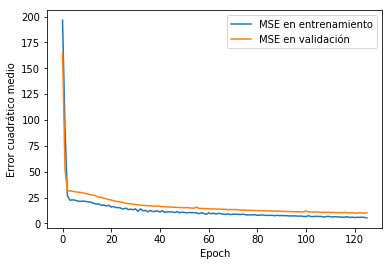

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f82691fccc0>
Batch size = 16
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)        9248  

<Figure size 432x288 with 0 Axes>

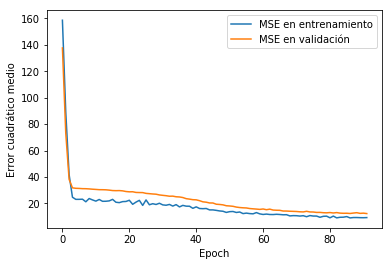

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f82691fcdd8>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)   

<Figure size 432x288 with 0 Axes>

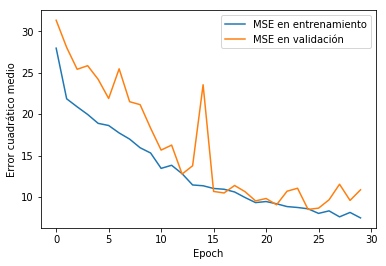

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f82691fcbe0>
Batch size = 8
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)   

<Figure size 432x288 with 0 Axes>

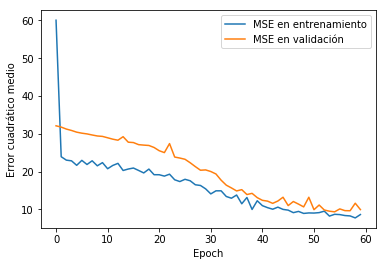

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f82691fc908>
Batch size = 16
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)  

<Figure size 432x288 with 0 Axes>

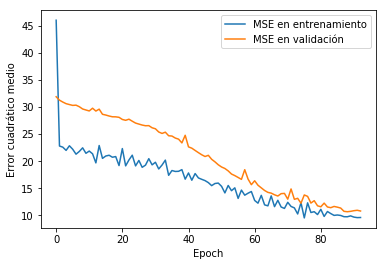

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f82691fce48>
Batch size = 4
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)    

Epoch 61/200
179/179 - 5s - loss: 7.2819 - val_loss: 10.8742
Epoch 62/200
179/179 - 5s - loss: 7.4097 - val_loss: 9.5181
Epoch 63/200
179/179 - 5s - loss: 6.9451 - val_loss: 10.3945
Epoch 64/200
179/179 - 5s - loss: 7.3190 - val_loss: 9.4511
Epoch 65/200
179/179 - 5s - loss: 6.6835 - val_loss: 9.4710
Tiempo total transcurrido: 337.32925939559937 seconds
38/38 [==============================] - 1s 24ms/step - loss: 7.7327
test_mse: 7.732724619539161
test_rmse: 2.7807777004894083


<Figure size 432x288 with 0 Axes>

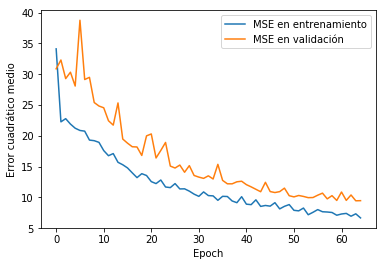

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f81e6d8b160>
Batch size = 8
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)    

<Figure size 432x288 with 0 Axes>

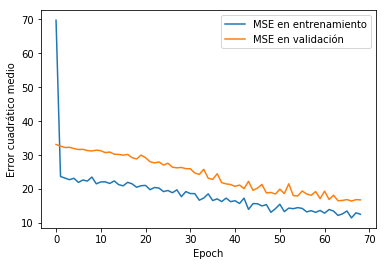

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f81e6d8b278>
Batch size = 16
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)   

<Figure size 432x288 with 0 Axes>

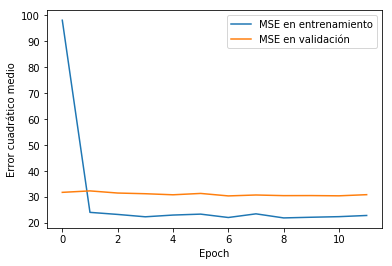

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f81e6d8b390>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248  

<Figure size 432x288 with 0 Axes>

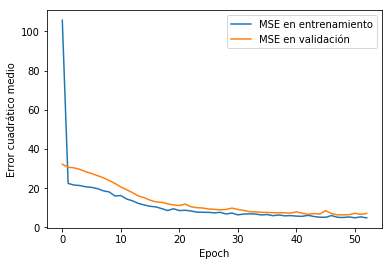

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f81e6d8b4a8>
Batch size = 8
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248  

<Figure size 432x288 with 0 Axes>

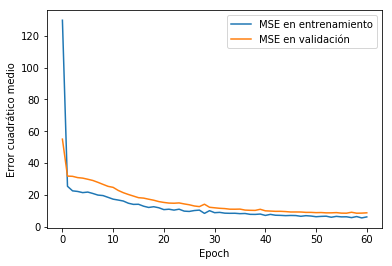

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f81e6d8b5c0>
Batch size = 16
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248 

<Figure size 432x288 with 0 Axes>

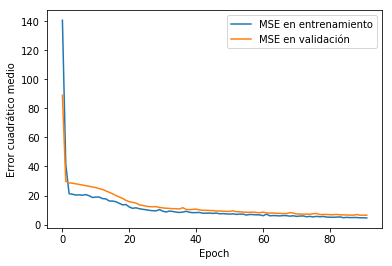

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f81e6d8b6a0>
Batch size = 4
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)        9248  

Epoch 23/200
179/179 - 5s - loss: 11.1044 - val_loss: 16.6598
Epoch 24/200
179/179 - 5s - loss: 12.0476 - val_loss: 16.5511
Epoch 25/200
179/179 - 5s - loss: 11.7626 - val_loss: 16.4335
Epoch 26/200
179/179 - 5s - loss: 10.8842 - val_loss: 16.6669
Epoch 27/200
179/179 - 5s - loss: 11.2627 - val_loss: 16.0773
Epoch 28/200
179/179 - 5s - loss: 11.2327 - val_loss: 15.7989
Epoch 29/200
179/179 - 5s - loss: 10.7359 - val_loss: 15.6670
Epoch 30/200
179/179 - 5s - loss: 10.9286 - val_loss: 15.5595
Epoch 31/200
179/179 - 5s - loss: 10.2449 - val_loss: 15.5468
Epoch 32/200
179/179 - 6s - loss: 11.0119 - val_loss: 15.3243
Epoch 33/200
179/179 - 5s - loss: 10.2303 - val_loss: 15.2890
Epoch 34/200
179/179 - 5s - loss: 10.0303 - val_loss: 15.5497
Epoch 35/200
179/179 - 5s - loss: 10.4523 - val_loss: 15.8111
Epoch 36/200
179/179 - 5s - loss: 10.1763 - val_loss: 15.1154
Epoch 37/200
179/179 - 5s - loss: 9.7373 - val_loss: 15.0678
Epoch 38/200
179/179 - 5s - loss: 9.6629 - val_loss: 14.5579
Epoch 39/2

<Figure size 432x288 with 0 Axes>

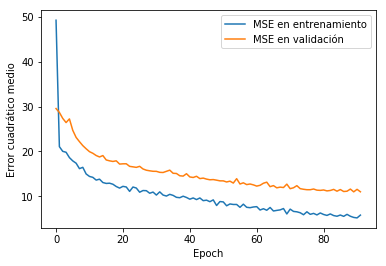

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f81e6d8b780>
Batch size = 8
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)        9248  

<Figure size 432x288 with 0 Axes>

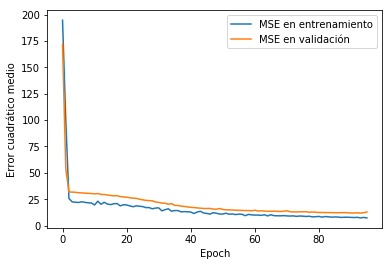

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f81e6d8b860>
Batch size = 16
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)        9248 

Epoch 63/200
44/44 - 4s - loss: 15.3566 - val_loss: 20.8335
Epoch 64/200
44/44 - 4s - loss: 13.8885 - val_loss: 20.6881
Epoch 65/200
44/44 - 4s - loss: 14.1568 - val_loss: 20.7918
Epoch 66/200
44/44 - 4s - loss: 14.6798 - val_loss: 20.6737
Epoch 67/200
44/44 - 4s - loss: 13.9523 - val_loss: 20.4216
Epoch 68/200
44/44 - 4s - loss: 15.2222 - val_loss: 20.4313
Epoch 69/200
44/44 - 4s - loss: 14.3111 - val_loss: 20.0415
Epoch 70/200
44/44 - 4s - loss: 14.3986 - val_loss: 19.7378
Epoch 71/200
44/44 - 4s - loss: 11.7872 - val_loss: 19.6649
Epoch 72/200
44/44 - 4s - loss: 15.0821 - val_loss: 19.7272
Epoch 73/200
44/44 - 4s - loss: 12.4658 - val_loss: 19.7957
Epoch 74/200
44/44 - 4s - loss: 15.0909 - val_loss: 19.2139
Epoch 75/200
44/44 - 4s - loss: 12.7029 - val_loss: 19.1308
Epoch 76/200
44/44 - 4s - loss: 12.7787 - val_loss: 19.1979
Epoch 77/200
44/44 - 4s - loss: 13.6974 - val_loss: 19.1312
Epoch 78/200
44/44 - 4s - loss: 13.4974 - val_loss: 18.6985
Epoch 79/200
44/44 - 4s - loss: 12.0680 

<Figure size 432x288 with 0 Axes>

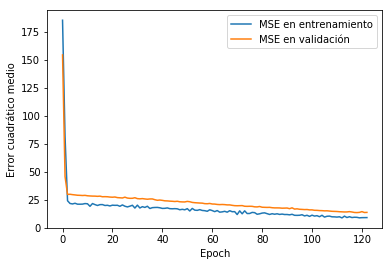

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f81e6d8b940>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)  

<Figure size 432x288 with 0 Axes>

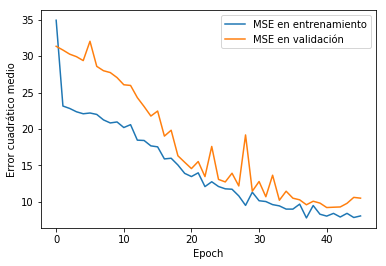

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f81e6d8ba20>
Batch size = 8
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)  

Epoch 63/200
89/89 - 8s - loss: 9.9768 - val_loss: 11.3623
Epoch 64/200
89/89 - 8s - loss: 10.0355 - val_loss: 13.2258
Epoch 65/200
89/89 - 8s - loss: 10.0911 - val_loss: 11.4244
Epoch 66/200
89/89 - 8s - loss: 11.3679 - val_loss: 12.7680
Epoch 67/200
89/89 - 8s - loss: 9.2395 - val_loss: 13.3254
Epoch 68/200
89/89 - 8s - loss: 10.6306 - val_loss: 12.2029
Tiempo total transcurrido: 526.0523443222046 seconds
19/19 [==============================] - 1s 54ms/step - loss: 9.8776
test_mse: 9.877611875534058
test_rmse: 3.1428668243395324


<Figure size 432x288 with 0 Axes>

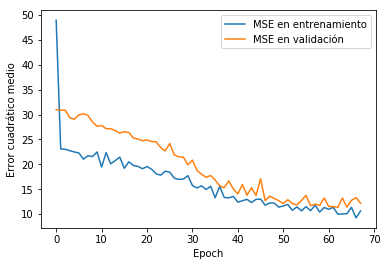

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f81e6d8bb00>
Batch size = 16
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32) 

<Figure size 432x288 with 0 Axes>

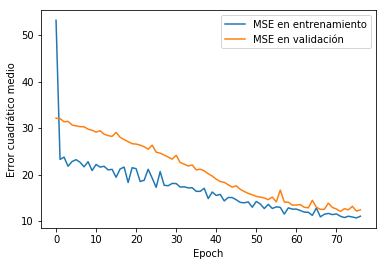

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f81e6d8bc18>
Batch size = 4
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)   

Epoch 61/200
179/179 - 5s - loss: 7.3957 - val_loss: 11.5084
Epoch 62/200
179/179 - 5s - loss: 8.2239 - val_loss: 10.2972
Epoch 63/200
179/179 - 5s - loss: 7.3540 - val_loss: 10.7757
Epoch 64/200
179/179 - 5s - loss: 7.2988 - val_loss: 10.8669
Epoch 65/200
179/179 - 5s - loss: 7.8426 - val_loss: 10.0996
Tiempo total transcurrido: 337.3287968635559 seconds
38/38 [==============================] - 1s 24ms/step - loss: 8.4550
test_mse: 8.455016743195685
test_rmse: 2.907751148773857


<Figure size 432x288 with 0 Axes>

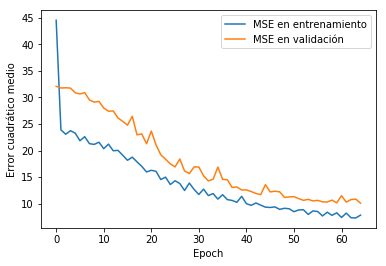

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f81e6d8bd30>
Batch size = 8
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)   

Epoch 24/200
89/89 - 5s - loss: 17.5575 - val_loss: 24.9109
Epoch 25/200
89/89 - 5s - loss: 17.8674 - val_loss: 23.5855
Epoch 26/200
89/89 - 5s - loss: 16.7815 - val_loss: 22.9221
Epoch 27/200
89/89 - 5s - loss: 16.4208 - val_loss: 23.3887
Epoch 28/200
89/89 - 5s - loss: 16.3750 - val_loss: 21.7504
Epoch 29/200
89/89 - 5s - loss: 15.6367 - val_loss: 22.4623
Epoch 30/200
89/89 - 5s - loss: 16.5877 - val_loss: 21.1584
Epoch 31/200
89/89 - 5s - loss: 14.4643 - val_loss: 19.6120
Epoch 32/200
89/89 - 5s - loss: 15.0004 - val_loss: 18.8913
Epoch 33/200
89/89 - 5s - loss: 13.4755 - val_loss: 20.7268
Epoch 34/200
89/89 - 5s - loss: 13.4004 - val_loss: 17.9110
Epoch 35/200
89/89 - 5s - loss: 14.4092 - val_loss: 17.9648
Epoch 36/200
89/89 - 4s - loss: 12.2836 - val_loss: 16.7182
Epoch 37/200
89/89 - 5s - loss: 12.6100 - val_loss: 16.2541
Epoch 38/200
89/89 - 5s - loss: 11.9126 - val_loss: 15.9472
Epoch 39/200
89/89 - 4s - loss: 12.8127 - val_loss: 16.3028
Epoch 40/200
89/89 - 5s - loss: 12.3697 

<Figure size 432x288 with 0 Axes>

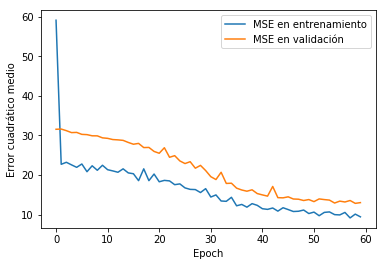

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f81e6d8be48>
Batch size = 16
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)  

Epoch 63/200
44/44 - 4s - loss: 14.1790 - val_loss: 19.3005
Epoch 64/200
44/44 - 4s - loss: 15.3990 - val_loss: 19.3731
Epoch 65/200
44/44 - 4s - loss: 14.7159 - val_loss: 19.0470
Epoch 66/200
44/44 - 4s - loss: 14.1692 - val_loss: 19.7137
Epoch 67/200
44/44 - 4s - loss: 14.4287 - val_loss: 18.4925
Epoch 68/200
44/44 - 4s - loss: 12.1039 - val_loss: 18.3231
Epoch 69/200
44/44 - 4s - loss: 14.9051 - val_loss: 18.3187
Epoch 70/200
44/44 - 4s - loss: 14.2272 - val_loss: 17.9568
Epoch 71/200
44/44 - 4s - loss: 12.9998 - val_loss: 18.7901
Epoch 72/200
44/44 - 4s - loss: 12.2863 - val_loss: 17.5982
Epoch 73/200
44/44 - 4s - loss: 14.8419 - val_loss: 17.8778
Epoch 74/200
44/44 - 4s - loss: 13.0875 - val_loss: 17.6440
Epoch 75/200
44/44 - 4s - loss: 12.5714 - val_loss: 17.5661
Epoch 76/200
44/44 - 4s - loss: 12.3086 - val_loss: 17.5432
Epoch 77/200
44/44 - 4s - loss: 13.1190 - val_loss: 17.2100
Epoch 78/200
44/44 - 4s - loss: 13.0636 - val_loss: 17.2110
Epoch 79/200
44/44 - 4s - loss: 12.6554 

<Figure size 432x288 with 0 Axes>

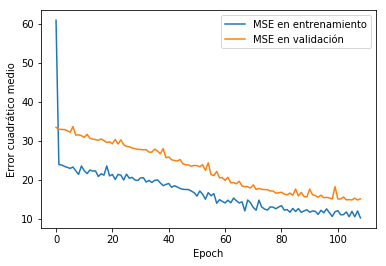

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f81e6d8bf60>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248 

<Figure size 432x288 with 0 Axes>

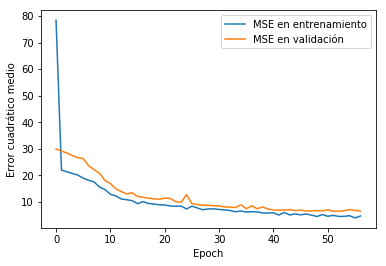

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f81e6d8b0f0>
Batch size = 8
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248 

<Figure size 432x288 with 0 Axes>

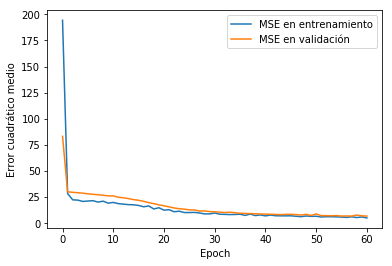

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f81e6d8a1d0>
Batch size = 16
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248

<Figure size 432x288 with 0 Axes>

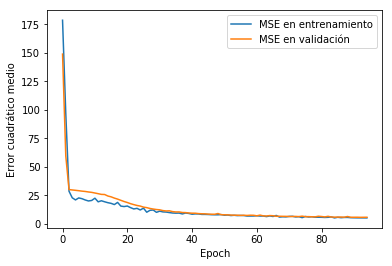

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f81e6d8a2b0>
Batch size = 4
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)        9248 

Epoch 61/200
179/179 - 5s - loss: 6.5052 - val_loss: 10.8451
Epoch 62/200
179/179 - 5s - loss: 7.4776 - val_loss: 11.3887
Epoch 63/200
179/179 - 5s - loss: 6.4090 - val_loss: 11.2213
Epoch 64/200
179/179 - 5s - loss: 6.1134 - val_loss: 10.9465
Epoch 65/200
179/179 - 5s - loss: 6.9211 - val_loss: 11.0355
Epoch 66/200
179/179 - 5s - loss: 6.9227 - val_loss: 10.6666
Epoch 67/200
179/179 - 5s - loss: 6.1230 - val_loss: 11.4135
Epoch 68/200
179/179 - 5s - loss: 6.7239 - val_loss: 10.5458
Epoch 69/200
179/179 - 5s - loss: 6.9188 - val_loss: 10.5005
Epoch 70/200
179/179 - 5s - loss: 5.6928 - val_loss: 10.3670
Epoch 71/200
179/179 - 5s - loss: 5.8079 - val_loss: 10.3211
Epoch 72/200
179/179 - 5s - loss: 6.5499 - val_loss: 11.3945
Epoch 73/200
179/179 - 5s - loss: 5.6945 - val_loss: 10.1956
Epoch 74/200
179/179 - 5s - loss: 6.7445 - val_loss: 10.2298
Epoch 75/200
179/179 - 5s - loss: 5.3498 - val_loss: 10.2849
Epoch 76/200
179/179 - 5s - loss: 6.5005 - val_loss: 10.4996
Epoch 77/200
179/179 - 5

<Figure size 432x288 with 0 Axes>

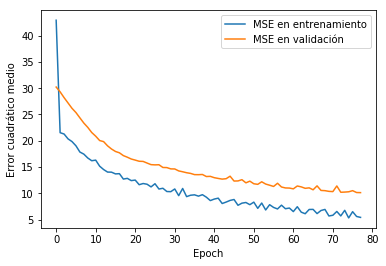

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f81e6d8a390>
Batch size = 8
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)        9248 

Epoch 102/200
89/89 - 5s - loss: 6.2268 - val_loss: 10.2442
Epoch 103/200
89/89 - 5s - loss: 6.0864 - val_loss: 10.1927
Epoch 104/200
89/89 - 5s - loss: 6.2246 - val_loss: 10.1182
Epoch 105/200
89/89 - 5s - loss: 5.6549 - val_loss: 10.3674
Epoch 106/200
89/89 - 5s - loss: 5.8542 - val_loss: 10.3204
Epoch 107/200
89/89 - 5s - loss: 5.7889 - val_loss: 10.5862
Epoch 108/200
89/89 - 5s - loss: 5.9502 - val_loss: 9.9814
Epoch 109/200
89/89 - 5s - loss: 5.9200 - val_loss: 9.9365
Epoch 110/200
89/89 - 5s - loss: 5.6978 - val_loss: 10.2635
Epoch 111/200
89/89 - 5s - loss: 5.7968 - val_loss: 9.9695
Epoch 112/200
89/89 - 5s - loss: 5.4408 - val_loss: 9.8849
Epoch 113/200
89/89 - 5s - loss: 5.8327 - val_loss: 9.8746
Epoch 114/200
89/89 - 5s - loss: 5.5443 - val_loss: 9.8311
Epoch 115/200
89/89 - 5s - loss: 5.5598 - val_loss: 10.2914
Epoch 116/200
89/89 - 5s - loss: 5.8917 - val_loss: 9.8082
Epoch 117/200
89/89 - 5s - loss: 5.3453 - val_loss: 9.8736
Epoch 118/200
89/89 - 5s - loss: 5.1531 - val_lo

<Figure size 432x288 with 0 Axes>

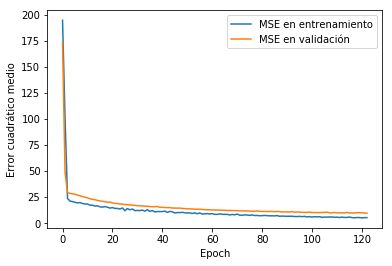

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f81e6d8a470>
Batch size = 16
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)        9248

Epoch 101/200
44/44 - 5s - loss: 9.4860 - val_loss: 12.8129
Epoch 102/200
44/44 - 5s - loss: 9.9194 - val_loss: 12.7267
Epoch 103/200
44/44 - 4s - loss: 9.8321 - val_loss: 12.6749
Epoch 104/200
44/44 - 4s - loss: 9.7040 - val_loss: 12.5925
Epoch 105/200
44/44 - 4s - loss: 9.4004 - val_loss: 12.5563
Epoch 106/200
44/44 - 4s - loss: 9.8006 - val_loss: 12.6851
Epoch 107/200
44/44 - 4s - loss: 9.5699 - val_loss: 12.4553
Epoch 108/200
44/44 - 4s - loss: 9.1924 - val_loss: 12.4453
Epoch 109/200
44/44 - 4s - loss: 9.2618 - val_loss: 12.4306
Epoch 110/200
44/44 - 4s - loss: 9.4195 - val_loss: 12.2587
Epoch 111/200
44/44 - 4s - loss: 9.2737 - val_loss: 12.1648
Epoch 112/200
44/44 - 4s - loss: 8.6604 - val_loss: 12.1451
Epoch 113/200
44/44 - 4s - loss: 9.2868 - val_loss: 12.1453
Epoch 114/200
44/44 - 4s - loss: 9.1491 - val_loss: 12.0727
Epoch 115/200
44/44 - 4s - loss: 9.1253 - val_loss: 12.1296
Epoch 116/200
44/44 - 4s - loss: 9.1827 - val_loss: 11.9068
Epoch 117/200
44/44 - 4s - loss: 9.2234 

<Figure size 432x288 with 0 Axes>

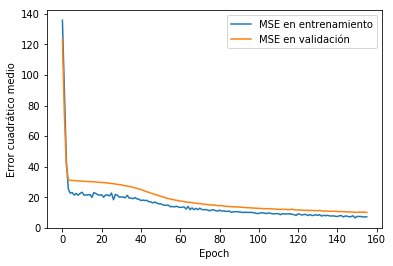

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f81e6d8a550>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32) 

<Figure size 432x288 with 0 Axes>

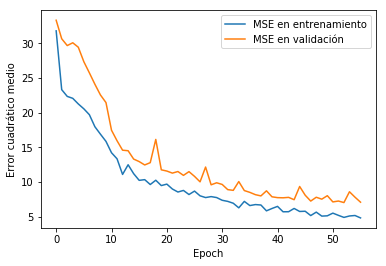

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f81e6d8a630>
Batch size = 8
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32) 

<Figure size 432x288 with 0 Axes>

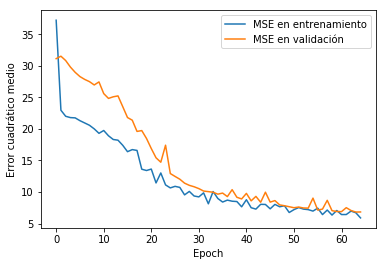

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f81e6d8a710>
Batch size = 16
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)

Epoch 63/200
44/44 - 7s - loss: 13.3247 - val_loss: 18.0922
Epoch 64/200
44/44 - 7s - loss: 14.2339 - val_loss: 17.7395
Epoch 65/200
44/44 - 7s - loss: 13.3445 - val_loss: 18.5559
Epoch 66/200
44/44 - 7s - loss: 13.6625 - val_loss: 17.0760
Epoch 67/200
44/44 - 7s - loss: 12.4661 - val_loss: 16.5726
Epoch 68/200
44/44 - 7s - loss: 13.2220 - val_loss: 16.3344
Epoch 69/200
44/44 - 7s - loss: 12.9198 - val_loss: 16.5943
Epoch 70/200
44/44 - 7s - loss: 12.2925 - val_loss: 15.9922
Epoch 71/200
44/44 - 7s - loss: 13.0232 - val_loss: 15.8399
Epoch 72/200
44/44 - 7s - loss: 11.8730 - val_loss: 18.6846
Epoch 73/200
44/44 - 7s - loss: 12.1743 - val_loss: 15.5402
Epoch 74/200
44/44 - 7s - loss: 13.0567 - val_loss: 15.3893
Epoch 75/200
44/44 - 7s - loss: 11.7284 - val_loss: 15.4887
Epoch 76/200
44/44 - 7s - loss: 11.4940 - val_loss: 15.6628
Epoch 77/200
44/44 - 7s - loss: 12.0187 - val_loss: 14.9683
Epoch 78/200
44/44 - 7s - loss: 11.8567 - val_loss: 16.9419
Epoch 79/200
44/44 - 7s - loss: 11.1414 

<Figure size 432x288 with 0 Axes>

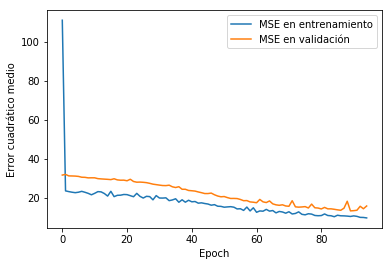

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f81e6d8a828>
Batch size = 4
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)  

<Figure size 432x288 with 0 Axes>

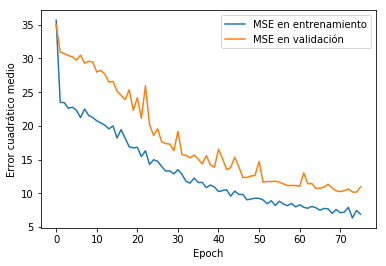

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f81e6d8a940>
Batch size = 8
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)  

<Figure size 432x288 with 0 Axes>

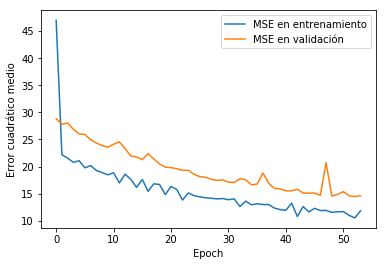

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f81e6d8aa58>
Batch size = 16
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32) 

<Figure size 432x288 with 0 Axes>

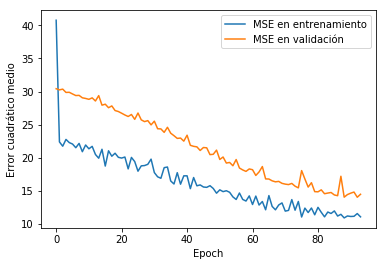

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



<Figure size 432x288 with 0 Axes>

In [9]:
summ_results_extra, histories_extra, test_losses_extra, times_extra, errors_extra = gridSearch(model_arqs_extra, max_epochs, patience, min_delta, train_data, imgs_path, x_col, y_col, "Extra", datagen)
summ_results_extra["Arq"] = "Extra"

summ_results_extra.to_csv("summ_results_extra.csv", index=False)

<a id='1_4_extra_filt'></a>
## 1.4 Extra_filt

Por último, se crea y se entrena la arquitectura con tres bloques convolucionales con número de filtros creciente ("extra_filt").

In [8]:
model_arqs_extra_filt = []
for learnRate in LearnRates:
    for optimizer in Optimizers:
        for size in Sizes:
            for batch in Batches:
                model_arq = ModelClass()

                model_arq.Capas=["Conv", "Conv", "Pool", "Conv", "Conv", "Pool", "Conv", "Conv", "Pool", "Flatten", "Dense", "Dense"]
                model_arq.Activations=["relu", "relu", "", "relu", "relu", "", "relu", "relu", "", "", "relu", "relu"]
                model_arq.Filtros=[8,8,0,16,16,0,32,32,0,0,0,0]
                model_arq.Tamanos=[3,3,4,3,3,4,3,3,4,0,512,1]

                model_arq.Batch = batch
                model_arq.optim_upd(optimizer)
                model_arq.target_width = size[0]
                model_arq.target_height = size[1]
                model_arq.LearnRate = learnRate
                model_arqs_extra_filt.append(model_arq)

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fec7a19f748>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 16)       1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 16)       2320   

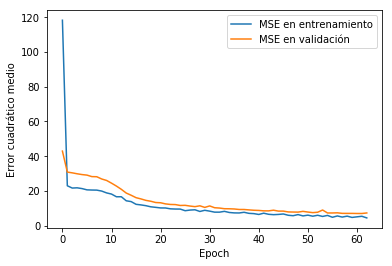

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fec7a146eb8>
Batch size = 8
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 16)       1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 16)       2320   

<Figure size 432x288 with 0 Axes>

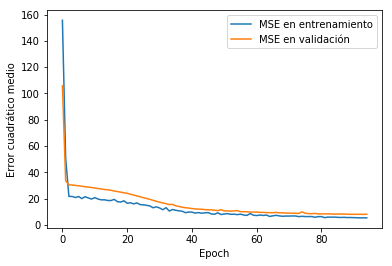

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fec7a146780>
Batch size = 16
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 16)       1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 16)       2320  

Epoch 102/200
44/44 - 5s - loss: 8.2604 - val_loss: 10.6890
Epoch 103/200
44/44 - 5s - loss: 7.8483 - val_loss: 11.3619
Epoch 104/200
44/44 - 5s - loss: 8.0191 - val_loss: 11.7621
Tiempo total transcurrido: 579.7149438858032 seconds
9/9 [==============================] - 1s 114ms/step - loss: 8.8753
test_mse: 8.875284194946289
test_rmse: 2.9791415197916145


<Figure size 432x288 with 0 Axes>

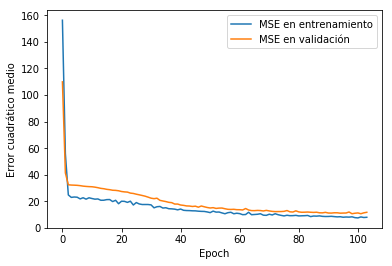

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fec7a1466d8>
Batch size = 4
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 16)        2320   

Epoch 98/200
179/179 - 5s - loss: 12.5626 - val_loss: 17.0689
Epoch 99/200
179/179 - 5s - loss: 12.3275 - val_loss: 16.7829
Epoch 100/200
179/179 - 5s - loss: 10.4540 - val_loss: 16.6943
Epoch 101/200
179/179 - 5s - loss: 11.7274 - val_loss: 16.6579
Epoch 102/200
179/179 - 5s - loss: 12.4574 - val_loss: 16.7399
Epoch 103/200
179/179 - 5s - loss: 11.2794 - val_loss: 16.5929
Epoch 104/200
179/179 - 5s - loss: 10.9618 - val_loss: 16.4436
Epoch 105/200
179/179 - 5s - loss: 11.9272 - val_loss: 16.3361
Epoch 106/200
179/179 - 5s - loss: 11.5772 - val_loss: 16.2408
Epoch 107/200
179/179 - 5s - loss: 10.7903 - val_loss: 16.3632
Epoch 108/200
179/179 - 5s - loss: 11.1095 - val_loss: 16.3603
Epoch 109/200
179/179 - 5s - loss: 11.4012 - val_loss: 16.1156
Epoch 110/200
179/179 - 5s - loss: 12.0294 - val_loss: 16.1089
Epoch 111/200
179/179 - 5s - loss: 9.6884 - val_loss: 15.9323
Epoch 112/200
179/179 - 5s - loss: 11.6214 - val_loss: 15.8785
Epoch 113/200
179/179 - 5s - loss: 10.5208 - val_loss: 16.

<Figure size 432x288 with 0 Axes>

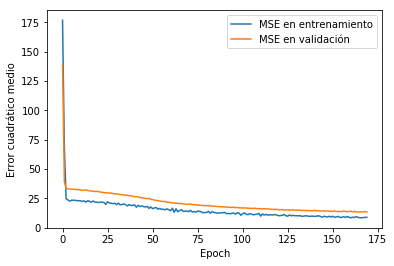

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fec7a146518>
Batch size = 8
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 16)        2320   

Epoch 102/200
89/89 - 5s - loss: 8.3840 - val_loss: 12.5469
Epoch 103/200
89/89 - 5s - loss: 8.1676 - val_loss: 12.6144
Epoch 104/200
89/89 - 5s - loss: 8.2415 - val_loss: 12.6500
Epoch 105/200
89/89 - 5s - loss: 8.6543 - val_loss: 12.3889
Epoch 106/200
89/89 - 4s - loss: 8.0470 - val_loss: 12.5850
Epoch 107/200
89/89 - 4s - loss: 7.9544 - val_loss: 12.3131
Epoch 108/200
89/89 - 5s - loss: 8.2329 - val_loss: 12.2981
Epoch 109/200
89/89 - 4s - loss: 8.0979 - val_loss: 12.1965
Epoch 110/200
89/89 - 4s - loss: 7.6239 - val_loss: 12.2543
Epoch 111/200
89/89 - 4s - loss: 8.1072 - val_loss: 12.1212
Epoch 112/200
89/89 - 4s - loss: 7.9960 - val_loss: 12.0596
Epoch 113/200
89/89 - 5s - loss: 7.9832 - val_loss: 12.0711
Epoch 114/200
89/89 - 5s - loss: 7.5799 - val_loss: 12.1071
Epoch 115/200
89/89 - 5s - loss: 8.0874 - val_loss: 12.3751
Epoch 116/200
89/89 - 5s - loss: 7.6553 - val_loss: 12.1334
Epoch 117/200
89/89 - 5s - loss: 7.9295 - val_loss: 12.1914
Tiempo total transcurrido: 567.193862676

<Figure size 432x288 with 0 Axes>

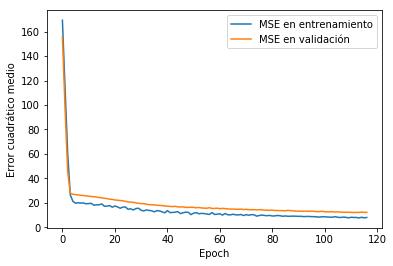

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fec7a146550>
Batch size = 16
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 16)        2320  

Epoch 63/200
44/44 - 4s - loss: 12.3607 - val_loss: 16.8971
Epoch 64/200
44/44 - 4s - loss: 13.6260 - val_loss: 16.8636
Epoch 65/200
44/44 - 4s - loss: 12.7789 - val_loss: 16.5582
Epoch 66/200
44/44 - 4s - loss: 13.6889 - val_loss: 16.4241
Epoch 67/200
44/44 - 4s - loss: 12.4184 - val_loss: 16.3247
Epoch 68/200
44/44 - 4s - loss: 12.1182 - val_loss: 16.3335
Epoch 69/200
44/44 - 4s - loss: 12.2725 - val_loss: 16.3136
Epoch 70/200
44/44 - 4s - loss: 12.4047 - val_loss: 16.0522
Epoch 71/200
44/44 - 4s - loss: 12.0534 - val_loss: 15.9776
Epoch 72/200
44/44 - 4s - loss: 12.8558 - val_loss: 15.8331
Epoch 73/200
44/44 - 4s - loss: 11.6135 - val_loss: 15.9085
Epoch 74/200
44/44 - 4s - loss: 12.4689 - val_loss: 15.6501
Epoch 75/200
44/44 - 4s - loss: 11.9384 - val_loss: 15.5582
Epoch 76/200
44/44 - 4s - loss: 11.4569 - val_loss: 15.4922
Epoch 77/200
44/44 - 4s - loss: 12.3438 - val_loss: 15.4136
Epoch 78/200
44/44 - 4s - loss: 11.1058 - val_loss: 15.5582
Epoch 79/200
44/44 - 4s - loss: 12.9116 

<Figure size 432x288 with 0 Axes>

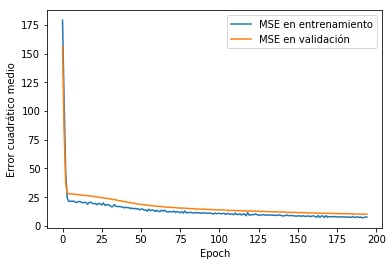

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fec7a146dd8>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 16)       1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 16)   

Epoch 61/200
179/179 - 6s - loss: 7.0101 - val_loss: 8.5125
Epoch 62/200
179/179 - 6s - loss: 6.3335 - val_loss: 8.0465
Tiempo total transcurrido: 351.1443772315979 seconds
38/38 [==============================] - 1s 26ms/step - loss: 7.0340
test_mse: 7.033992293633912
test_rmse: 2.6521674708875214


<Figure size 432x288 with 0 Axes>

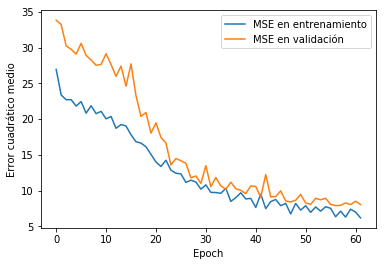

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fec7a146ac8>
Batch size = 8
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 16)       1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 16)   

<Figure size 432x288 with 0 Axes>

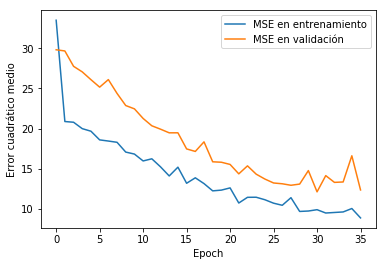

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fec7a146cf8>
Batch size = 16
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 16)       1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 16)  

<Figure size 432x288 with 0 Axes>

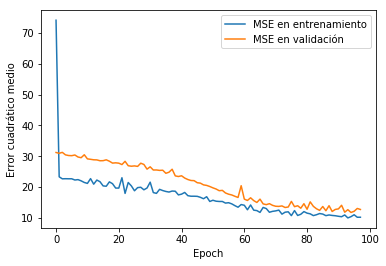

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fec7a1469b0>
Batch size = 4
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 16)    

<Figure size 432x288 with 0 Axes>

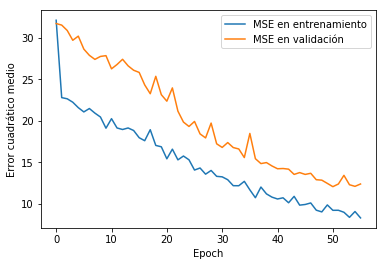

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fec7a146710>
Batch size = 8
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 16)    

Epoch 63/200
89/89 - 4s - loss: 10.0830 - val_loss: 12.7032
Epoch 64/200
89/89 - 4s - loss: 9.6619 - val_loss: 12.9818
Epoch 65/200
89/89 - 4s - loss: 9.4664 - val_loss: 12.3595
Epoch 66/200
89/89 - 4s - loss: 10.0888 - val_loss: 12.3773
Epoch 67/200
89/89 - 4s - loss: 9.5037 - val_loss: 12.2958
Epoch 68/200
89/89 - 4s - loss: 10.4497 - val_loss: 12.1608
Epoch 69/200
89/89 - 4s - loss: 9.1163 - val_loss: 12.2211
Epoch 70/200
89/89 - 4s - loss: 9.1293 - val_loss: 12.2605
Epoch 71/200
89/89 - 4s - loss: 9.7651 - val_loss: 11.9171
Epoch 72/200
89/89 - 4s - loss: 9.7734 - val_loss: 11.9231
Epoch 73/200
89/89 - 4s - loss: 9.5015 - val_loss: 11.9462
Epoch 74/200
89/89 - 4s - loss: 9.0186 - val_loss: 11.7249
Epoch 75/200
89/89 - 4s - loss: 9.8220 - val_loss: 11.7076
Epoch 76/200
89/89 - 4s - loss: 9.2750 - val_loss: 11.7043
Epoch 77/200
89/89 - 4s - loss: 8.8723 - val_loss: 11.5482
Epoch 78/200
89/89 - 4s - loss: 9.5873 - val_loss: 11.4892
Epoch 79/200
89/89 - 4s - loss: 8.9602 - val_loss: 11

<Figure size 432x288 with 0 Axes>

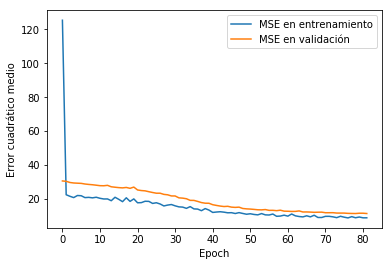

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fec7a110208>
Batch size = 16
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 16)   

<Figure size 432x288 with 0 Axes>

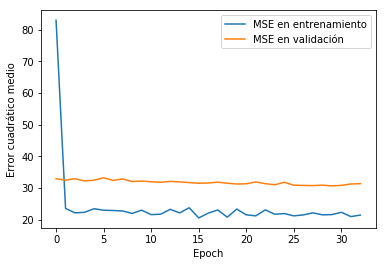

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fec7a110320>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 16)       1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 16)       2320  

<Figure size 432x288 with 0 Axes>

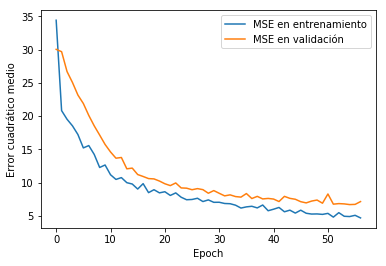

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fec7a110438>
Batch size = 8
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 16)       1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 16)       2320  

Epoch 64/200
89/89 - 5s - loss: 5.2266 - val_loss: 8.1530
Epoch 65/200
89/89 - 5s - loss: 5.6659 - val_loss: 7.7740
Epoch 66/200
89/89 - 5s - loss: 5.5420 - val_loss: 7.7146
Epoch 67/200
89/89 - 5s - loss: 5.6566 - val_loss: 7.9617
Epoch 68/200
89/89 - 5s - loss: 5.4033 - val_loss: 7.4886
Epoch 69/200
89/89 - 5s - loss: 5.5337 - val_loss: 7.7919
Epoch 70/200
89/89 - 5s - loss: 4.9841 - val_loss: 7.5190
Epoch 71/200
89/89 - 5s - loss: 5.4916 - val_loss: 7.4232
Epoch 72/200
89/89 - 5s - loss: 5.1027 - val_loss: 7.4054
Epoch 73/200
89/89 - 5s - loss: 5.2175 - val_loss: 7.1835
Epoch 74/200
89/89 - 5s - loss: 5.1656 - val_loss: 7.1816
Epoch 75/200
89/89 - 5s - loss: 4.8488 - val_loss: 7.2670
Epoch 76/200
89/89 - 5s - loss: 5.0455 - val_loss: 7.0452
Epoch 77/200
89/89 - 5s - loss: 4.8966 - val_loss: 7.0536
Epoch 78/200
89/89 - 5s - loss: 5.0049 - val_loss: 7.6101
Epoch 79/200
89/89 - 5s - loss: 4.5140 - val_loss: 7.1144
Epoch 80/200
89/89 - 5s - loss: 4.7930 - val_loss: 6.9608
Epoch 81/200
8

<Figure size 432x288 with 0 Axes>

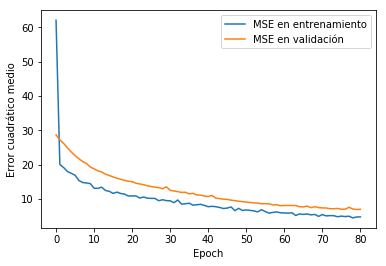

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fec7a110550>
Batch size = 16
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 16)       1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 16)       2320 

Epoch 63/200
44/44 - 5s - loss: 9.7183 - val_loss: 10.2278
Epoch 64/200
44/44 - 5s - loss: 8.8025 - val_loss: 10.2352
Epoch 65/200
44/44 - 5s - loss: 8.7291 - val_loss: 10.0447
Epoch 66/200
44/44 - 5s - loss: 9.1434 - val_loss: 10.2457
Epoch 67/200
44/44 - 5s - loss: 8.8099 - val_loss: 10.0823
Epoch 68/200
44/44 - 5s - loss: 9.4880 - val_loss: 9.7683
Epoch 69/200
44/44 - 5s - loss: 8.4342 - val_loss: 9.7596
Epoch 70/200
44/44 - 5s - loss: 9.0595 - val_loss: 9.6345
Epoch 71/200
44/44 - 5s - loss: 9.0377 - val_loss: 9.5354
Epoch 72/200
44/44 - 5s - loss: 8.0905 - val_loss: 9.5436
Epoch 73/200
44/44 - 5s - loss: 8.1314 - val_loss: 9.5756
Epoch 74/200
44/44 - 5s - loss: 8.8353 - val_loss: 9.3629
Epoch 75/200
44/44 - 5s - loss: 8.9528 - val_loss: 9.2788
Epoch 76/200
44/44 - 5s - loss: 8.4900 - val_loss: 9.2489
Epoch 77/200
44/44 - 5s - loss: 7.8292 - val_loss: 9.3363
Epoch 78/200
44/44 - 5s - loss: 8.7252 - val_loss: 9.1769
Epoch 79/200
44/44 - 5s - loss: 7.7828 - val_loss: 9.4019
Epoch 80/

<Figure size 432x288 with 0 Axes>

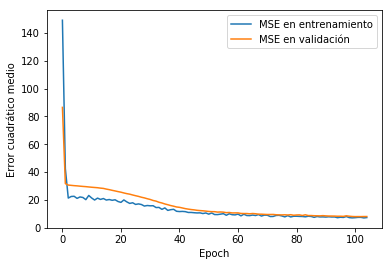

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fec7a110630>
Batch size = 4
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 16)        2320  

Epoch 99/200
179/179 - 5s - loss: 7.2814 - val_loss: 11.4033
Epoch 100/200
179/179 - 5s - loss: 7.6962 - val_loss: 11.9079
Epoch 101/200
179/179 - 5s - loss: 7.5699 - val_loss: 11.5913
Epoch 102/200
179/179 - 5s - loss: 7.4426 - val_loss: 11.7176
Epoch 103/200
179/179 - 5s - loss: 7.2529 - val_loss: 11.5432
Epoch 104/200
179/179 - 5s - loss: 7.4884 - val_loss: 11.6943
Tiempo total transcurrido: 525.7636044025421 seconds
38/38 [==============================] - 1s 24ms/step - loss: 8.6453
test_mse: 8.645292683651572
test_rmse: 2.9402878572771702


<Figure size 432x288 with 0 Axes>

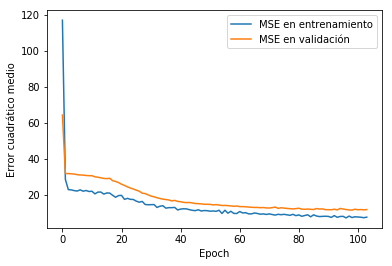

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fec7a110710>
Batch size = 8
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 16)        2320  

Epoch 101/200
89/89 - 5s - loss: 11.0821 - val_loss: 16.8548
Epoch 102/200
89/89 - 4s - loss: 12.1697 - val_loss: 16.0368
Epoch 103/200
89/89 - 4s - loss: 12.4511 - val_loss: 15.9896
Epoch 104/200
89/89 - 4s - loss: 11.1386 - val_loss: 15.8189
Epoch 105/200
89/89 - 4s - loss: 12.1777 - val_loss: 15.7851
Epoch 106/200
89/89 - 4s - loss: 11.2856 - val_loss: 15.7244
Epoch 107/200
89/89 - 4s - loss: 12.1148 - val_loss: 15.8403
Epoch 108/200
89/89 - 4s - loss: 11.2508 - val_loss: 15.7759
Epoch 109/200
89/89 - 4s - loss: 10.9120 - val_loss: 15.5636
Epoch 110/200
89/89 - 4s - loss: 11.6712 - val_loss: 15.5389
Epoch 111/200
89/89 - 4s - loss: 12.0708 - val_loss: 15.4814
Epoch 112/200
89/89 - 4s - loss: 11.2847 - val_loss: 15.9334
Epoch 113/200
89/89 - 4s - loss: 11.6150 - val_loss: 15.4260
Epoch 114/200
89/89 - 4s - loss: 11.6013 - val_loss: 15.3047
Epoch 115/200
89/89 - 4s - loss: 11.1248 - val_loss: 15.2963
Epoch 116/200
89/89 - 4s - loss: 9.9307 - val_loss: 15.2437
Epoch 117/200
89/89 - 4s 

<Figure size 432x288 with 0 Axes>

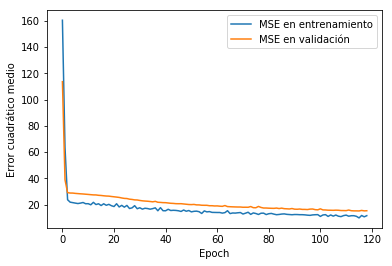

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fec7a1107f0>
Batch size = 16
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 16)        2320 

Epoch 101/200
44/44 - 4s - loss: 15.4650 - val_loss: 22.4084
Epoch 102/200
44/44 - 4s - loss: 15.7924 - val_loss: 22.3822
Epoch 103/200
44/44 - 4s - loss: 16.7635 - val_loss: 22.2504
Epoch 104/200
44/44 - 4s - loss: 14.7982 - val_loss: 22.2014
Epoch 105/200
44/44 - 4s - loss: 16.2145 - val_loss: 22.1008
Epoch 106/200
44/44 - 4s - loss: 15.4476 - val_loss: 22.3369
Epoch 107/200
44/44 - 4s - loss: 15.6290 - val_loss: 21.9547
Epoch 108/200
44/44 - 4s - loss: 16.4147 - val_loss: 21.8727
Epoch 109/200
44/44 - 4s - loss: 15.2941 - val_loss: 21.7896
Epoch 110/200
44/44 - 4s - loss: 15.1893 - val_loss: 21.9611
Epoch 111/200
44/44 - 4s - loss: 14.9329 - val_loss: 21.8471
Epoch 112/200
44/44 - 4s - loss: 15.0174 - val_loss: 21.5487
Epoch 113/200
44/44 - 4s - loss: 15.7497 - val_loss: 21.4599
Epoch 114/200
44/44 - 4s - loss: 15.6133 - val_loss: 21.4556
Epoch 115/200
44/44 - 4s - loss: 14.9152 - val_loss: 21.3653
Epoch 116/200
44/44 - 4s - loss: 14.9690 - val_loss: 21.2373
Epoch 117/200
44/44 - 4s

<Figure size 432x288 with 0 Axes>

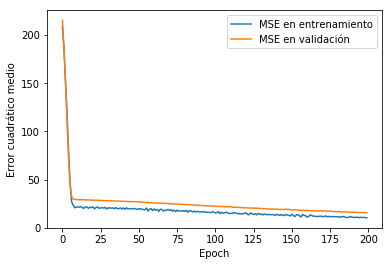

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fec7a1108d0>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 16)       1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 16)  

<Figure size 432x288 with 0 Axes>

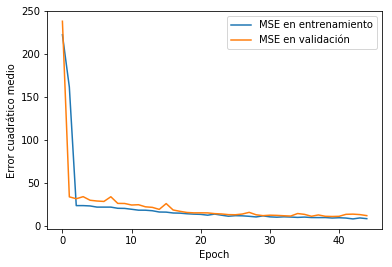

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fec7a1109b0>
Batch size = 8
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 16)       1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 16)  

<Figure size 432x288 with 0 Axes>

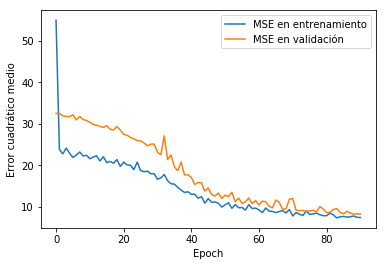

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fec7a110a90>
Batch size = 16
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 16)       1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 16) 

Epoch 24/200
44/44 - 5s - loss: 20.7218 - val_loss: 28.8493
Epoch 25/200
44/44 - 5s - loss: 19.5966 - val_loss: 28.6815
Epoch 26/200
44/44 - 5s - loss: 20.3123 - val_loss: 28.5507
Epoch 27/200
44/44 - 5s - loss: 20.9345 - val_loss: 28.3112
Epoch 28/200
44/44 - 5s - loss: 19.7578 - val_loss: 28.1311
Epoch 29/200
44/44 - 5s - loss: 19.7144 - val_loss: 28.0025
Epoch 30/200
44/44 - 5s - loss: 19.9512 - val_loss: 27.7468
Epoch 31/200
44/44 - 5s - loss: 18.7734 - val_loss: 27.8187
Epoch 32/200
44/44 - 5s - loss: 19.7427 - val_loss: 27.4398
Epoch 33/200
44/44 - 5s - loss: 19.1253 - val_loss: 27.3474
Epoch 34/200
44/44 - 5s - loss: 19.9041 - val_loss: 26.9436
Epoch 35/200
44/44 - 5s - loss: 19.3564 - val_loss: 26.9650
Epoch 36/200
44/44 - 5s - loss: 17.9064 - val_loss: 26.6162
Epoch 37/200
44/44 - 5s - loss: 18.1565 - val_loss: 26.5245
Epoch 38/200
44/44 - 5s - loss: 19.8709 - val_loss: 26.1043
Epoch 39/200
44/44 - 5s - loss: 18.1495 - val_loss: 26.1119
Epoch 40/200
44/44 - 5s - loss: 17.9145 

<Figure size 432x288 with 0 Axes>

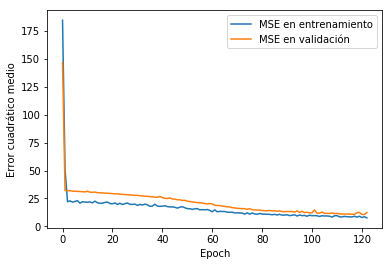

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fec7a110ba8>
Batch size = 4
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 16)   

<Figure size 432x288 with 0 Axes>

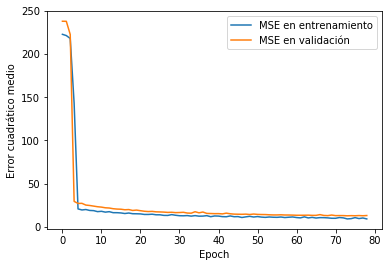

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fec7a110cc0>
Batch size = 8
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 16)   

Epoch 101/200
89/89 - 4s - loss: 10.8942 - val_loss: 15.4776
Epoch 102/200
89/89 - 4s - loss: 11.3287 - val_loss: 17.8118
Epoch 103/200
89/89 - 4s - loss: 11.9735 - val_loss: 14.5772
Epoch 104/200
89/89 - 4s - loss: 10.0423 - val_loss: 14.4965
Epoch 105/200
89/89 - 4s - loss: 11.8767 - val_loss: 15.2481
Epoch 106/200
89/89 - 4s - loss: 10.5107 - val_loss: 16.0188
Epoch 107/200
89/89 - 4s - loss: 10.1999 - val_loss: 15.1542
Epoch 108/200
89/89 - 4s - loss: 11.9036 - val_loss: 14.3005
Epoch 109/200
89/89 - 4s - loss: 10.3801 - val_loss: 14.5328
Epoch 110/200
89/89 - 4s - loss: 10.5457 - val_loss: 15.0636
Epoch 111/200
89/89 - 4s - loss: 10.6724 - val_loss: 14.1863
Epoch 112/200
89/89 - 4s - loss: 10.3241 - val_loss: 14.5702
Epoch 113/200
89/89 - 4s - loss: 10.6690 - val_loss: 13.9489
Epoch 114/200
89/89 - 4s - loss: 10.3387 - val_loss: 14.1765
Epoch 115/200
89/89 - 4s - loss: 10.5581 - val_loss: 15.2522
Epoch 116/200
89/89 - 4s - loss: 10.4351 - val_loss: 14.1944
Epoch 117/200
89/89 - 4s

<Figure size 432x288 with 0 Axes>

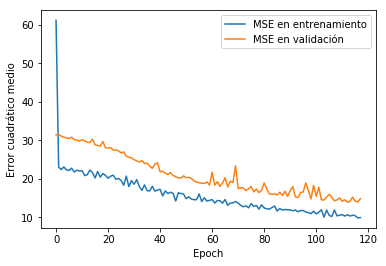

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fec7a110dd8>
Batch size = 16
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 16)  

<Figure size 432x288 with 0 Axes>

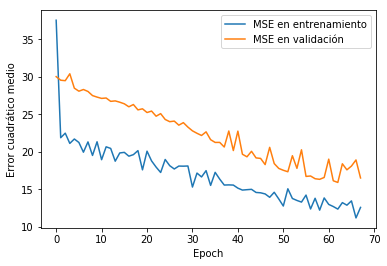

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fec7a110ef0>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 16)       1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 16)       2320 

<Figure size 432x288 with 0 Axes>

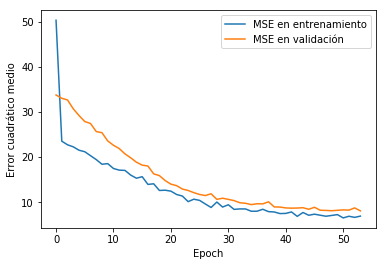

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fec7a110198>
Batch size = 8
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 16)       1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 16)       2320 

Epoch 63/200
89/89 - 5s - loss: 7.2560 - val_loss: 11.0299
Epoch 64/200
89/89 - 5s - loss: 7.7781 - val_loss: 10.7056
Epoch 65/200
89/89 - 5s - loss: 6.2775 - val_loss: 10.8845
Epoch 66/200
89/89 - 5s - loss: 7.1598 - val_loss: 10.4821
Epoch 67/200
89/89 - 5s - loss: 7.4877 - val_loss: 10.7994
Epoch 68/200
89/89 - 5s - loss: 6.4864 - val_loss: 10.3513
Epoch 69/200
89/89 - 5s - loss: 6.9711 - val_loss: 10.1498
Epoch 70/200
89/89 - 5s - loss: 6.8290 - val_loss: 10.0993
Epoch 71/200
89/89 - 5s - loss: 6.8592 - val_loss: 10.7956
Epoch 72/200
89/89 - 5s - loss: 6.6588 - val_loss: 10.4671
Epoch 73/200
89/89 - 5s - loss: 6.6055 - val_loss: 9.8434
Epoch 74/200
89/89 - 5s - loss: 6.0974 - val_loss: 10.1270
Epoch 75/200
89/89 - 5s - loss: 6.1331 - val_loss: 10.6946
Epoch 76/200
89/89 - 5s - loss: 7.0014 - val_loss: 9.5978
Epoch 77/200
89/89 - 5s - loss: 5.9314 - val_loss: 9.5205
Epoch 78/200
89/89 - 5s - loss: 6.3208 - val_loss: 9.4726
Epoch 79/200
89/89 - 5s - loss: 6.2529 - val_loss: 9.9672
Ep

<Figure size 432x288 with 0 Axes>

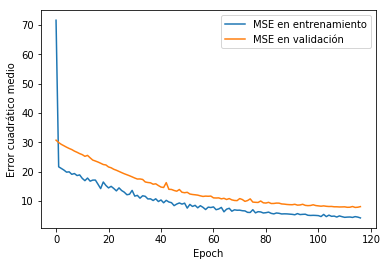

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fec7a0ee160>
Batch size = 16
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 16)       1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 16)       2320

<Figure size 432x288 with 0 Axes>

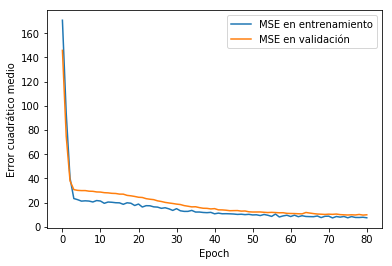

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fec7a0ee240>
Batch size = 4
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 16)        2320 

Epoch 98/200
179/179 - 5s - loss: 8.5767 - val_loss: 13.5218
Epoch 99/200
179/179 - 5s - loss: 9.4780 - val_loss: 13.5084
Epoch 100/200
179/179 - 5s - loss: 8.4334 - val_loss: 13.1760
Epoch 101/200
179/179 - 5s - loss: 9.2221 - val_loss: 12.8028
Epoch 102/200
179/179 - 5s - loss: 8.0819 - val_loss: 12.7488
Epoch 103/200
179/179 - 5s - loss: 8.6592 - val_loss: 12.7892
Epoch 104/200
179/179 - 5s - loss: 9.0503 - val_loss: 12.6775
Epoch 105/200
179/179 - 5s - loss: 7.9682 - val_loss: 12.9676
Epoch 106/200
179/179 - 5s - loss: 8.5334 - val_loss: 12.5266
Epoch 107/200
179/179 - 5s - loss: 8.5090 - val_loss: 12.5901
Epoch 108/200
179/179 - 5s - loss: 8.5934 - val_loss: 12.5571
Epoch 109/200
179/179 - 5s - loss: 8.6205 - val_loss: 12.4781
Epoch 110/200
179/179 - 5s - loss: 8.0837 - val_loss: 12.3891
Epoch 111/200
179/179 - 5s - loss: 7.6299 - val_loss: 12.3451
Epoch 112/200
179/179 - 5s - loss: 8.3966 - val_loss: 12.2726
Epoch 113/200
179/179 - 5s - loss: 8.4024 - val_loss: 12.3068
Epoch 114/

<Figure size 432x288 with 0 Axes>

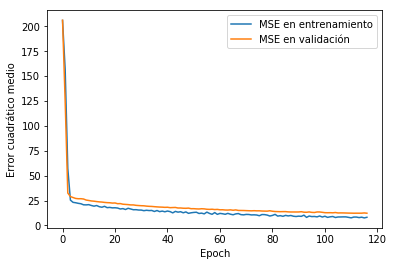

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fec7a0ee320>
Batch size = 8
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 16)        2320 

Epoch 63/200
89/89 - 4s - loss: 12.2763 - val_loss: 15.6028
Epoch 64/200
89/89 - 4s - loss: 11.8597 - val_loss: 16.1574
Epoch 65/200
89/89 - 4s - loss: 11.8384 - val_loss: 15.4176
Epoch 66/200
89/89 - 4s - loss: 12.5888 - val_loss: 15.5274
Epoch 67/200
89/89 - 5s - loss: 11.0204 - val_loss: 15.3641
Epoch 68/200
89/89 - 4s - loss: 12.5236 - val_loss: 15.1077
Epoch 69/200
89/89 - 4s - loss: 12.7944 - val_loss: 15.0393
Epoch 70/200
89/89 - 5s - loss: 10.9074 - val_loss: 14.9739
Epoch 71/200
89/89 - 4s - loss: 11.8370 - val_loss: 14.9335
Epoch 72/200
89/89 - 4s - loss: 12.5064 - val_loss: 14.8090
Epoch 73/200
89/89 - 4s - loss: 11.1091 - val_loss: 14.8449
Epoch 74/200
89/89 - 4s - loss: 11.8111 - val_loss: 14.7681
Epoch 75/200
89/89 - 4s - loss: 10.5274 - val_loss: 14.9378
Epoch 76/200
89/89 - 4s - loss: 12.3552 - val_loss: 14.5675
Epoch 77/200
89/89 - 4s - loss: 10.4901 - val_loss: 14.6043
Epoch 78/200
89/89 - 4s - loss: 12.3838 - val_loss: 14.6085
Epoch 79/200
89/89 - 4s - loss: 11.2725 

<Figure size 432x288 with 0 Axes>

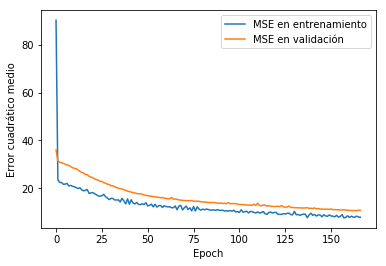

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fec7a0ee400>
Batch size = 16
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 16)        2320

Epoch 101/200
44/44 - 4s - loss: 12.4198 - val_loss: 15.8771
Epoch 102/200
44/44 - 4s - loss: 11.3981 - val_loss: 15.8057
Epoch 103/200
44/44 - 4s - loss: 12.0574 - val_loss: 15.8296
Epoch 104/200
44/44 - 4s - loss: 11.7151 - val_loss: 15.6975
Epoch 105/200
44/44 - 4s - loss: 11.8745 - val_loss: 15.6013
Epoch 106/200
44/44 - 4s - loss: 11.8077 - val_loss: 15.5301
Epoch 107/200
44/44 - 4s - loss: 11.7385 - val_loss: 15.4811
Epoch 108/200
44/44 - 4s - loss: 11.5709 - val_loss: 15.4278
Epoch 109/200
44/44 - 4s - loss: 11.2227 - val_loss: 15.3762
Epoch 110/200
44/44 - 4s - loss: 12.1666 - val_loss: 15.2914
Epoch 111/200
44/44 - 4s - loss: 10.6329 - val_loss: 15.2645
Epoch 112/200
44/44 - 4s - loss: 12.0991 - val_loss: 15.2829
Epoch 113/200
44/44 - 4s - loss: 10.5720 - val_loss: 15.1511
Epoch 114/200
44/44 - 4s - loss: 11.7226 - val_loss: 15.1811
Epoch 115/200
44/44 - 4s - loss: 10.8884 - val_loss: 15.0413
Epoch 116/200
44/44 - 4s - loss: 12.2306 - val_loss: 15.0095
Epoch 117/200
44/44 - 4s

<Figure size 432x288 with 0 Axes>

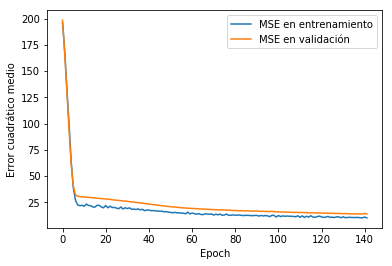

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fec7a0ee4e0>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 16)       1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 16) 

<Figure size 432x288 with 0 Axes>

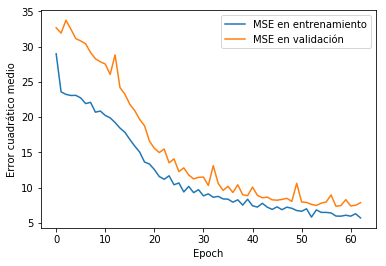

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fec7a0ee5c0>
Batch size = 8
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 16)       1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 16) 

Epoch 63/200
89/89 - 5s - loss: 8.2657 - val_loss: 11.1123
Epoch 64/200
89/89 - 5s - loss: 7.8344 - val_loss: 10.9598
Epoch 65/200
89/89 - 5s - loss: 8.4791 - val_loss: 10.9592
Epoch 66/200
89/89 - 5s - loss: 7.9611 - val_loss: 11.5680
Epoch 67/200
89/89 - 5s - loss: 7.9386 - val_loss: 11.0640
Epoch 68/200
89/89 - 5s - loss: 7.9999 - val_loss: 10.8454
Epoch 69/200
89/89 - 5s - loss: 7.8466 - val_loss: 10.7519
Epoch 70/200
89/89 - 5s - loss: 8.1917 - val_loss: 10.6906
Epoch 71/200
89/89 - 5s - loss: 7.9205 - val_loss: 10.9431
Epoch 72/200
89/89 - 5s - loss: 7.5033 - val_loss: 11.6813
Epoch 73/200
89/89 - 5s - loss: 8.1322 - val_loss: 10.5795
Epoch 74/200
89/89 - 5s - loss: 7.2755 - val_loss: 10.7337
Epoch 75/200
89/89 - 5s - loss: 7.8151 - val_loss: 10.7396
Epoch 76/200
89/89 - 5s - loss: 7.8579 - val_loss: 11.0387
Epoch 77/200
89/89 - 5s - loss: 7.1837 - val_loss: 10.4557
Epoch 78/200
89/89 - 5s - loss: 7.5816 - val_loss: 11.0989
Epoch 79/200
89/89 - 5s - loss: 7.9490 - val_loss: 10.39

<Figure size 432x288 with 0 Axes>

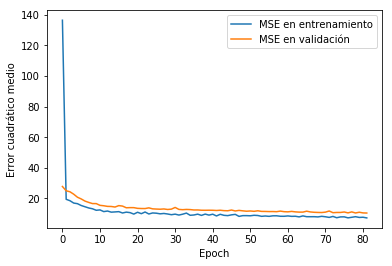

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fec7a0ee6a0>
Batch size = 16
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 16)       1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 16)

<Figure size 432x288 with 0 Axes>

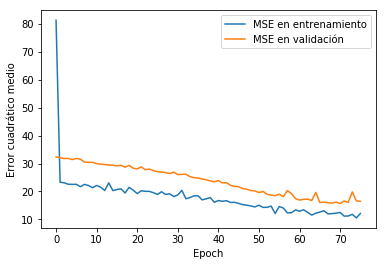

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fec7a0ee7b8>
Batch size = 4
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 16)  

<Figure size 432x288 with 0 Axes>

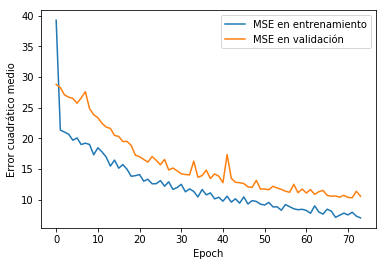

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fec7a0ee8d0>
Batch size = 8
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 16)  

Epoch 101/200
89/89 - 5s - loss: 11.5677 - val_loss: 14.5766
Epoch 102/200
89/89 - 4s - loss: 11.2181 - val_loss: 14.5957
Epoch 103/200
89/89 - 4s - loss: 11.0972 - val_loss: 14.4601
Epoch 104/200
89/89 - 4s - loss: 11.5581 - val_loss: 14.1346
Epoch 105/200
89/89 - 4s - loss: 11.4401 - val_loss: 14.0771
Epoch 106/200
89/89 - 4s - loss: 11.5397 - val_loss: 13.9727
Epoch 107/200
89/89 - 4s - loss: 11.0695 - val_loss: 13.8757
Epoch 108/200
89/89 - 4s - loss: 10.5381 - val_loss: 13.8413
Epoch 109/200
89/89 - 4s - loss: 11.6463 - val_loss: 13.9453
Epoch 110/200
89/89 - 4s - loss: 10.7849 - val_loss: 13.6369
Epoch 111/200
89/89 - 4s - loss: 11.1265 - val_loss: 14.1336
Epoch 112/200
89/89 - 4s - loss: 9.9965 - val_loss: 13.6820
Epoch 113/200
89/89 - 4s - loss: 11.2648 - val_loss: 13.4183
Epoch 114/200
89/89 - 4s - loss: 9.9916 - val_loss: 13.3912
Epoch 115/200
89/89 - 4s - loss: 10.1170 - val_loss: 17.3830
Epoch 116/200
89/89 - 4s - loss: 11.2053 - val_loss: 13.3555
Epoch 117/200
89/89 - 4s -

<Figure size 432x288 with 0 Axes>

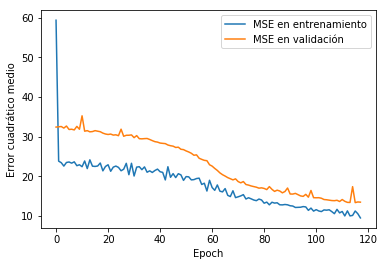

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fec7a0ee9e8>
Batch size = 16
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 16) 

Epoch 24/200
44/44 - 4s - loss: 17.3458 - val_loss: 18.8197
Epoch 25/200
44/44 - 4s - loss: 16.2068 - val_loss: 18.6622
Epoch 26/200
44/44 - 4s - loss: 16.1005 - val_loss: 18.4377
Epoch 27/200
44/44 - 4s - loss: 16.6500 - val_loss: 18.2742
Epoch 28/200
44/44 - 4s - loss: 16.0902 - val_loss: 18.1467
Epoch 29/200
44/44 - 4s - loss: 16.0794 - val_loss: 17.8704
Epoch 30/200
44/44 - 4s - loss: 16.0892 - val_loss: 17.7186
Epoch 31/200
44/44 - 4s - loss: 15.8746 - val_loss: 17.5508
Epoch 32/200
44/44 - 4s - loss: 15.3841 - val_loss: 17.4396
Epoch 33/200
44/44 - 4s - loss: 15.9852 - val_loss: 17.2489
Epoch 34/200
44/44 - 4s - loss: 15.2283 - val_loss: 17.2185
Epoch 35/200
44/44 - 4s - loss: 15.5900 - val_loss: 17.0139
Epoch 36/200
44/44 - 4s - loss: 15.3581 - val_loss: 16.9218
Epoch 37/200
44/44 - 4s - loss: 15.8074 - val_loss: 16.8260
Epoch 38/200
44/44 - 4s - loss: 15.0445 - val_loss: 16.6383
Epoch 39/200
44/44 - 4s - loss: 15.2830 - val_loss: 16.5668
Epoch 40/200
44/44 - 4s - loss: 14.4414 

<Figure size 432x288 with 0 Axes>

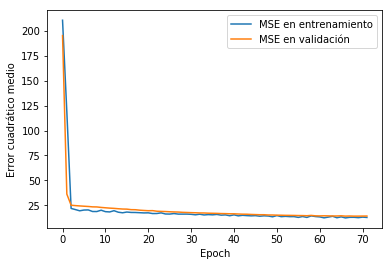

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



<Figure size 432x288 with 0 Axes>

In [9]:
summ_results_extra_filt, histories_extra_filt, test_losses_extra_filt, times_extra_filt, errors_extra_filt = gridSearch(model_arqs_extra_filt, max_epochs, patience, min_delta, train_data, imgs_path, x_col, y_col, "Extra_filt", datagen)
summ_results_extra_filt["Arq"] = "Extra_filt"

summ_results_extra_filt.to_csv("summ_results_extra_filt.csv", index=False)

In [7]:
summ_results_base = pd.read_csv("summ_results_base.csv")
summ_results_extra = pd.read_csv("summ_results_extra.csv")
summ_results_extra_filt = pd.read_csv("summ_results_extra_filt.csv")

<a id='2_modelo_preentrenado'></a>
# 2. Modelo pre-entrenado
En esta segunda aproximación, en lugar de crear una red neuronal convolucional y entrenarla desde cero, se va usar la red pre-entrenada VGG16.

Al modelo pre-entrenado, le añadimos un bloque totalmente conectado para poder resolver nuestro problema de regresión. Primero, no vamos a modificar los pesos originales de la red pre-entrenada. En un segundo paso, sí que los vamos a modificar haciendo fine-tuning.


<a id='2_1_transfer_learning'></a>
## 2.1 Transfer learning

De forma análoga a la primera aproximación, definimos una clase para esta arquitectura y una función que entrene el modelo.

In [8]:
class ModelTransfLearnClass:
    """
  Esta clase es una forma cómoda de poder definir diferentes estructuras de redes
  neuronales a partir de sus hiperparámetros.
    """

    loss = "mse"

    def __init__(self
               , LearnRate = 1e-5
               , Optimizer="Adam"
               , Batch=4
               , target_width = 400
               , target_height = 400
               , base_model="VGG16"
               , trainable=False):
    
        self.LearnRate = LearnRate
        self.Optimizer = optimizers.Adam(lr=LearnRate)
        self.Batch = Batch
        self.target_width = target_width
        self.target_height = target_height
        self.base_model = base_model
        self.trainable = trainable

    def optim_upd(self,Optimizer):
        if Optimizer == "Adam":
            self.Optimizer = optimizers.Adam(lr=self.LearnRate)
        elif Optimizer == "SGD":
            self.Optimizer = optimizers.SGD(lr=self.LearnRate)

In [9]:
def gridSearch_tf(model_arqs, max_epochs, patience, min_delta, train_data, imgs_path, x_col, y_col, prefix, datagen):

    # Estas listas almacenerán los resultados de cada una de las CNN
    histories = []
    test_losses = []
    times = []
    errors = []

    for model_arq in model_arqs:

        # Generamos los batches con los datos para las tres particiones
        batch_size = model_arq.Batch
        target_height = model_arq.target_height
        target_width = model_arq.target_width
        
        train_generator = datagen.flow_from_dataframe(dataframe=train_data, directory=imgs_path, x_col=x_col, y_col=y_col, 
                                                class_mode="raw", target_size=(target_width,target_height), batch_size=batch_size)
        dev_generator = datagen.flow_from_dataframe(dataframe=dev_data, directory=imgs_path, x_col=x_col, y_col=y_col,
                                                class_mode="raw", target_size=(target_width,target_height), batch_size=batch_size)
        test_generator = datagen.flow_from_dataframe(dataframe=test_data, directory=imgs_path, x_col=x_col, y_col=y_col,
                                                class_mode="raw", target_size=(target_width,target_height), batch_size=batch_size)

        
        # Imprimimos por pantalla el modelo
        print("Learning rate = " + str(model_arq.LearnRate))
        print("Optimizer = " + str(model_arq.Optimizer))
        print("Batch size = " + str(model_arq.Batch))
        print("Base model = " + str(model_arq.base_model))
        print("Width = " + str(model_arq.target_width) + ", height = " + str(model_arq.target_height))
        
        try:
            for i in range(0,3): # probamos un máximo de 3 veces si no puede empezar a entrenar
                if model_arq.base_model == "VGG16":
                    model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(model_arq.target_width, model_arq.target_height,3))

                for layer in model.layers:
                    layer.trainable = model_arq.trainable 

                # Añadimos nuevas capas al final para adaptar el modelo a nuestro problema de regresión
                x = model.output
                x = GlobalMaxPooling2D()(x)
                x = Dense(8192, activation='relu', kernel_initializer=initializers.he_normal())(x) 
                x = Dense(512, activation='relu', kernel_initializer=initializers.he_normal())(x) 

                # Añadimos una última capa con una neurona, ya que es un problema de regresión
                predictions = Dense(1, activation='relu', kernel_initializer=initializers.he_normal())(x) 


                model = Model(inputs=[model.input], outputs=[predictions])
                model.summary()

                model.compile(loss=model_arq.loss,
                              optimizer=model_arq.Optimizer 
                              )

                es = EarlyStopping(monitor='val_loss', mode='min', min_delta=min_delta, patience=patience, restore_best_weights=True)
                start_time = time.time()

                results = model.fit_generator(train_generator,
                                epochs=max_epochs,
                                verbose=2,
                                steps_per_epoch=int(len(train_data)/batch_size),
                                validation_data=dev_generator,
                                validation_steps=int(len(dev_data)/batch_size),
                                callbacks=[es])
                
                if results.history["loss"][-1]<200:
                    break
                    
            histories.append(results)
            
        except ResourceExhaustedError:
            print("¡¡¡ Not enough available resources !!! (ResourceExhaustedError)")
            print(" Next iteration...")
            errors.append([model_arq.LearnRate, model_arq.Optimizer, model_arq.Batch, model_arq.target_width, model_arq.target_height])
            continue

        except InternalError:
            print("¡¡¡ Not enough available resources !!! (InternalError)")
            print(" Next iteration...")
            errors.append([model_arq.LearnRate, model_arq.Optimizer, model_arq.Batch, model_arq.target_width, model_arq.target_height])
            continue

        times.append(time.time() - start_time)
        print("Tiempo total transcurrido: " +str(times[len(times)-1]) + " seconds")

        # Entrenamos en el conjunto de test
        test_losses.append(model.evaluate_generator(test_generator,
                                            steps=int(len(test_data)/batch_size),
                                            verbose=1)
        )

        print("test_mse: " + str(test_losses[len(test_losses)-1]))
        print("test_rmse: " + str(np.sqrt(test_losses[len(test_losses)-1])))

        # Dibujamos la curva de entrenamiento para la muestra de entrenamiento y la de validación
        name_graph = str(prefix)+"_LR"+str(model_arq.LearnRate)+"_OPT"+str(model_arq.Optimizer)[len("keras.optimizers.")+1:str(model_arq.Optimizer).find(" ")]+"_BASZ"+str(model_arq.Batch)+"_WD"+str(model_arq.target_width)+".jpg"
        plot_history(histories[len(histories)-1], name_file=name_graph)

        for i in range(0,5):
            tf.reset_default_graph()
            try:
                del model
            except:
                pass
            K.clear_session()
            gc.collect()
        time.sleep(5) # dejamos 5 segundos para que se enfríe un poco la GPU y la CPU

    # Guardamos un resumen de los resultados en un DataFrame
    summ_results = pd.DataFrame(columns=['LearnRate', 'Optimizer', 'Batch', 'Width', 'Height', 'Train_loss', 'Val_loss', 'Test_loss', 'Time'])
    i=0
    j=0
    for model_arq in model_arqs:
        if errors==[]:
            trainLoss = histories[i].history["loss"][-1-patience]
            valLoss = histories[i].history["val_loss"][-1-patience]
            testLoss = test_losses[i]
            trainTime = times[i]
        else:
            for error in errors:
                if (( (model_arq.LearnRate == error[0]) & (str(model_arq.Optimizer) == str(error[1])) & (model_arq.Batch == error[2]) & (model_arq.target_width == error[3]) & (model_arq.target_height == error[4])) |  len(histories)<= i ):
                    trainLoss = -1
                    valLoss = -1
                    testLoss = -1
                    trainTime = -1
                    i = i-1
                    break
                else:
                    trainLoss = histories[i].history["loss"][-1-patience]
                    valLoss = histories[i].history["val_loss"][-1-patience]
                    testLoss = test_losses[i]
                    trainTime = times[i]
        i = i+1
        tmp = pd.DataFrame(data={'LearnRate': str(model_arq.LearnRate), 'Optimizer': str(model_arq.Optimizer), 'Batch': str(model_arq.Batch), 
                               'Width': str(model_arq.target_width), 'Height': str(model_arq.target_height), 'Train_loss' : trainLoss,
                               'Val_loss' : valLoss, 'Test_loss': testLoss, 'Time' : trainTime }, index=[j])
        summ_results = pd.concat([summ_results, tmp])
        j=j+1
        
    return summ_results, histories, test_losses, times, errors

Especificamos los hiper-parámetros que vamos a intentar optimizar y definimos los diferentes modelos.

In [9]:
max_epochs = 200
patience = 5
min_delta = 0.1

Base_models = ["VGG16"]
LearnRates = [1e-1, 1e-2, 1e-3]
Optimizers = ["Adam","SGD"]
Batches = [4, 8, 16]   
Sizes = [[int(img_width/i), int(img_height/i)] for i in [6, 9]]

model_arqs_transf_learn = []

# Arquitectura base
for learnRate in LearnRates:
    for optimizer in Optimizers:
        for size in Sizes:
            for batch in Batches:
                for base_model in Base_models:
                    model_arq = ModelTransfLearnClass()
                    model_arq.Batch = batch
                    model_arq.optim_upd(optimizer)
                    model_arq.target_width = size[0]
                    model_arq.target_height = size[1]
                    model_arq.LearnRate = learnRate
                    model_arqs_transf_learn.append(model_arq)

Se entrenan los modelos.

W0608 21:41:19.968427 140571052640000 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fd8b1edb8d0>
Batch size = 4
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 272, 204, 12

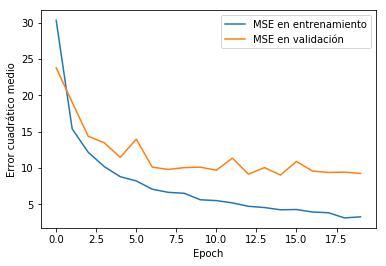

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fd8b1efd198>
Batch size = 8
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 272, 204, 12

Epoch 14/200
89/89 - 25s - loss: 5.3888 - val_loss: 10.8937
Epoch 15/200
89/89 - 25s - loss: 5.7443 - val_loss: 9.2910
Epoch 16/200
89/89 - 25s - loss: 5.1678 - val_loss: 9.1763
Epoch 17/200
89/89 - 25s - loss: 4.7643 - val_loss: 9.1137
Epoch 18/200
89/89 - 25s - loss: 4.6145 - val_loss: 9.0906
Epoch 19/200
89/89 - 25s - loss: 4.5619 - val_loss: 9.1701
Epoch 20/200
89/89 - 25s - loss: 4.4594 - val_loss: 9.5818
Epoch 21/200
89/89 - 25s - loss: 4.2178 - val_loss: 9.0424
Epoch 22/200
89/89 - 25s - loss: 4.1734 - val_loss: 9.1638
Epoch 23/200
89/89 - 25s - loss: 4.1566 - val_loss: 8.9719
Epoch 24/200
89/89 - 25s - loss: 3.9267 - val_loss: 9.5114
Epoch 25/200
89/89 - 25s - loss: 3.9844 - val_loss: 9.4984
Epoch 26/200
89/89 - 25s - loss: 3.5642 - val_loss: 9.6584
Tiempo total transcurrido: 652.9973771572113 seconds
19/19 [==============================] - 4s 235ms/step - loss: 8.4846
test_mse: 8.48460662992377
test_rmse: 2.9128348099272245


<Figure size 432x288 with 0 Axes>

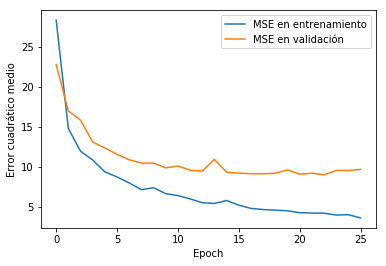

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fd8b1efd2b0>
Batch size = 16
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 272, 204, 1

<Figure size 432x288 with 0 Axes>

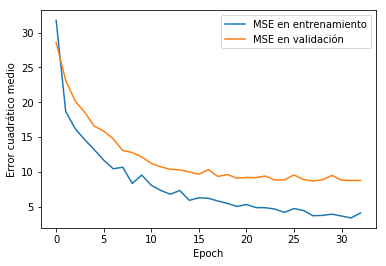

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fd8b1efd518>
Batch size = 4
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 181, 136, 12

<Figure size 432x288 with 0 Axes>

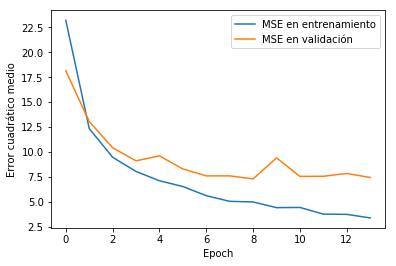

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fd8b1efd5f8>
Batch size = 8
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 181, 136, 12

<Figure size 432x288 with 0 Axes>

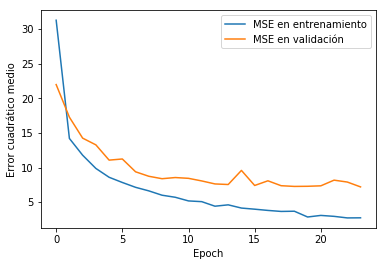

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fd8b1efd4e0>
Batch size = 16
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 181, 136, 1

<Figure size 432x288 with 0 Axes>

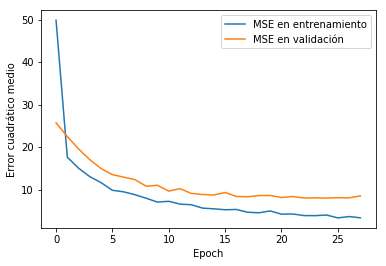

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fd8b1efdda0>
Batch size = 4
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 2

Epoch 13/200
179/179 - 26s - loss: 9.7061 - val_loss: 12.7542
Epoch 14/200
179/179 - 26s - loss: 8.7109 - val_loss: 14.7422
Epoch 15/200
179/179 - 26s - loss: 9.2769 - val_loss: 14.5260
Epoch 16/200
179/179 - 26s - loss: 8.6215 - val_loss: 12.4912
Epoch 17/200
179/179 - 26s - loss: 8.2499 - val_loss: 15.4160
Epoch 18/200
179/179 - 26s - loss: 8.4262 - val_loss: 11.8853
Epoch 19/200
179/179 - 26s - loss: 8.2747 - val_loss: 12.6968
Epoch 20/200
179/179 - 26s - loss: 7.9930 - val_loss: 11.5463
Epoch 21/200
179/179 - 26s - loss: 7.0773 - val_loss: 10.8854
Epoch 22/200
179/179 - 26s - loss: 8.0016 - val_loss: 10.7577
Epoch 23/200
179/179 - 26s - loss: 7.2376 - val_loss: 10.8511
Epoch 24/200
179/179 - 26s - loss: 7.1578 - val_loss: 11.8842
Epoch 25/200
179/179 - 26s - loss: 7.5828 - val_loss: 10.3915
Epoch 26/200
179/179 - 26s - loss: 6.8352 - val_loss: 10.2031
Epoch 27/200
179/179 - 26s - loss: 6.5392 - val_loss: 13.5536
Epoch 28/200
179/179 - 26s - loss: 7.2877 - val_loss: 10.5925
Epoch 29

<Figure size 432x288 with 0 Axes>

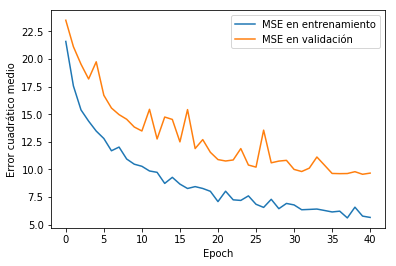

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fd8b1efdeb8>
Batch size = 8
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 2

<Figure size 432x288 with 0 Axes>

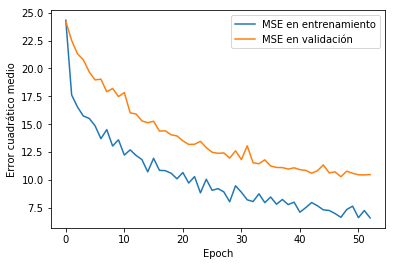

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fd8b1efd668>
Batch size = 16
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 

Epoch 76/200
44/44 - 24s - loss: 8.3440 - val_loss: 10.9413
Epoch 77/200
44/44 - 24s - loss: 8.0751 - val_loss: 10.8666
Epoch 78/200
44/44 - 24s - loss: 8.0605 - val_loss: 10.8155
Epoch 79/200
44/44 - 24s - loss: 8.1387 - val_loss: 10.8297
Epoch 80/200
44/44 - 24s - loss: 7.8823 - val_loss: 10.7267
Epoch 81/200
44/44 - 24s - loss: 8.2355 - val_loss: 10.9793
Epoch 82/200
44/44 - 24s - loss: 7.3043 - val_loss: 10.8198
Epoch 83/200
44/44 - 24s - loss: 8.1277 - val_loss: 10.5909
Epoch 84/200
44/44 - 24s - loss: 8.0408 - val_loss: 10.5554
Epoch 85/200
44/44 - 24s - loss: 7.7783 - val_loss: 10.5271
Epoch 86/200
44/44 - 24s - loss: 7.8742 - val_loss: 11.2118
Epoch 87/200
44/44 - 24s - loss: 7.6663 - val_loss: 10.7694
Epoch 88/200
44/44 - 24s - loss: 7.7343 - val_loss: 10.5367
Tiempo total transcurrido: 2113.1810944080353 seconds
9/9 [==============================] - 4s 463ms/step - loss: 9.7106
test_mse: 9.710624800788032
test_rmse: 3.116187542621277


<Figure size 432x288 with 0 Axes>

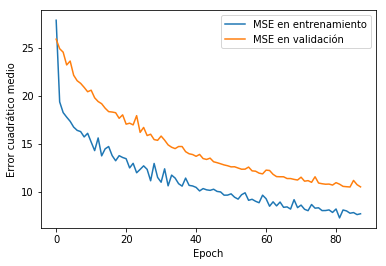

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fd8b1efd780>
Batch size = 4
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 1

<Figure size 432x288 with 0 Axes>

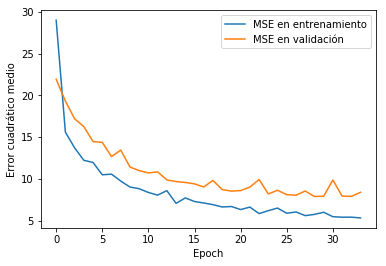

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fd8b1efd7b8>
Batch size = 8
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 1

<Figure size 432x288 with 0 Axes>

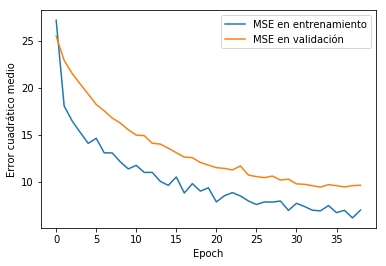

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fd8b1efde48>
Batch size = 16
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 

44/44 - 11s - loss: 6.5446 - val_loss: 8.8031
Epoch 77/200
44/44 - 11s - loss: 6.2856 - val_loss: 8.9305
Epoch 78/200
44/44 - 11s - loss: 6.2850 - val_loss: 8.6424
Epoch 79/200
44/44 - 11s - loss: 6.6028 - val_loss: 8.8387
Epoch 80/200
44/44 - 11s - loss: 6.2737 - val_loss: 8.5467
Epoch 81/200
44/44 - 11s - loss: 6.1252 - val_loss: 8.5632
Epoch 82/200
44/44 - 11s - loss: 6.3169 - val_loss: 8.4922
Epoch 83/200
44/44 - 11s - loss: 5.8384 - val_loss: 8.4532
Epoch 84/200
44/44 - 11s - loss: 6.5478 - val_loss: 8.4186
Epoch 85/200
44/44 - 11s - loss: 5.9627 - val_loss: 8.4292
Epoch 86/200
44/44 - 11s - loss: 5.9326 - val_loss: 8.4109
Epoch 87/200
44/44 - 11s - loss: 6.2582 - val_loss: 8.4078
Epoch 88/200
44/44 - 11s - loss: 6.1035 - val_loss: 8.3447
Epoch 89/200
44/44 - 11s - loss: 5.9699 - val_loss: 8.3881
Tiempo total transcurrido: 981.9345619678497 seconds
9/9 [==============================] - 2s 216ms/step - loss: 6.0147
test_mse: 6.014740811453925
test_rmse: 2.452496852486038


<Figure size 432x288 with 0 Axes>

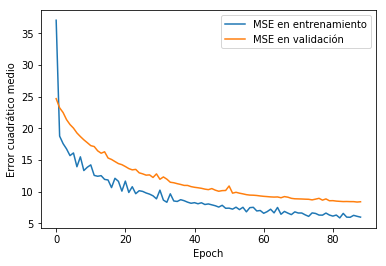

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fd8b1efdf98>
Batch size = 4
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 272, 204, 1

<Figure size 432x288 with 0 Axes>

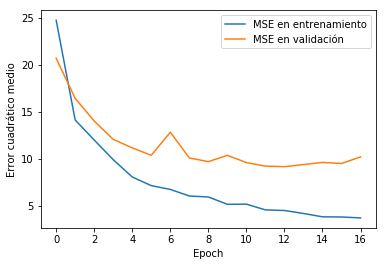

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fd8b1efd320>
Batch size = 8
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 272, 204, 1

Epoch 14/200
89/89 - 25s - loss: 5.5460 - val_loss: 9.4231
Epoch 15/200
89/89 - 25s - loss: 4.9018 - val_loss: 9.5576
Epoch 16/200
89/89 - 25s - loss: 4.6774 - val_loss: 10.4511
Epoch 17/200
89/89 - 25s - loss: 4.7518 - val_loss: 9.4772
Epoch 18/200
89/89 - 25s - loss: 4.6573 - val_loss: 9.2168
Epoch 19/200
89/89 - 25s - loss: 4.1443 - val_loss: 9.5555
Epoch 20/200
89/89 - 25s - loss: 3.9740 - val_loss: 9.1714
Epoch 21/200
89/89 - 25s - loss: 4.2693 - val_loss: 9.2001
Epoch 22/200
89/89 - 25s - loss: 3.5390 - val_loss: 9.5572
Epoch 23/200
89/89 - 25s - loss: 3.7458 - val_loss: 9.2191
Tiempo total transcurrido: 577.4564316272736 seconds
19/19 [==============================] - 4s 234ms/step - loss: 8.4276
test_mse: 8.427615241000527
test_rmse: 2.903035521828923


<Figure size 432x288 with 0 Axes>

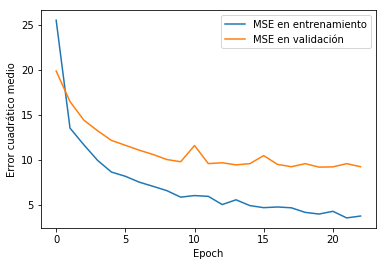

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fd8b1efdcc0>
Batch size = 16
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 272, 204, 

<Figure size 432x288 with 0 Axes>

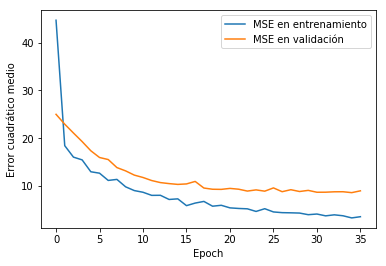

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fd8b1efda90>
Batch size = 4
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 181, 136, 1

<Figure size 432x288 with 0 Axes>

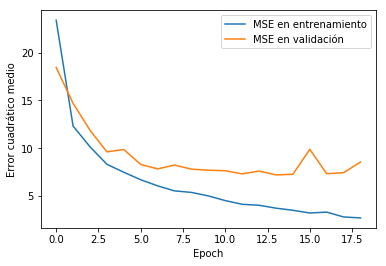

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fd8b1e8d2b0>
Batch size = 8
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 181, 136, 1

Epoch 14/200
89/89 - 12s - loss: 4.3255 - val_loss: 7.7319
Epoch 15/200
89/89 - 12s - loss: 4.0998 - val_loss: 8.2649
Epoch 16/200
89/89 - 12s - loss: 4.0580 - val_loss: 7.5743
Epoch 17/200
89/89 - 12s - loss: 3.9947 - val_loss: 7.5699
Epoch 18/200
89/89 - 12s - loss: 3.9183 - val_loss: 7.5894
Tiempo total transcurrido: 215.51457619667053 seconds
19/19 [==============================] - 2s 111ms/step - loss: 5.5672
test_mse: 5.567239334708766
test_rmse: 2.359499806041265


<Figure size 432x288 with 0 Axes>

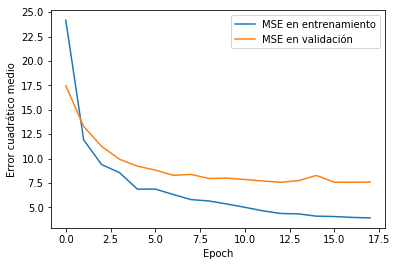

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fd8b1e8d390>
Batch size = 16
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 181, 136, 

<Figure size 432x288 with 0 Axes>

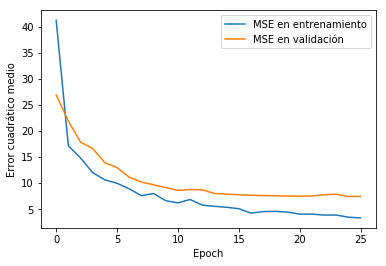

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fd8b1e8d470>
Batch size = 4
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 

<Figure size 432x288 with 0 Axes>

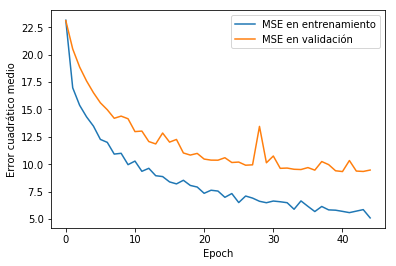

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fd8b1e8d550>
Batch size = 8
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 

<Figure size 432x288 with 0 Axes>

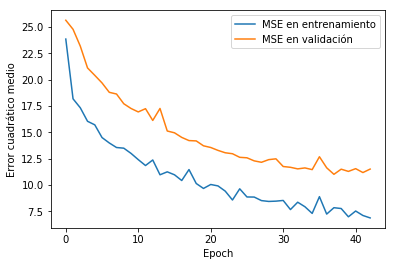

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fd8b1e8d668>
Batch size = 16
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None,

Epoch 76/200
44/44 - 24s - loss: 7.2203 - val_loss: 11.5577
Epoch 77/200
44/44 - 24s - loss: 7.4523 - val_loss: 11.5246
Epoch 78/200
44/44 - 24s - loss: 8.2981 - val_loss: 11.3206
Epoch 79/200
44/44 - 24s - loss: 7.6583 - val_loss: 11.4276
Epoch 80/200
44/44 - 24s - loss: 7.2124 - val_loss: 11.3104
Epoch 81/200
44/44 - 24s - loss: 7.8096 - val_loss: 11.2636
Epoch 82/200
44/44 - 24s - loss: 8.0049 - val_loss: 11.1357
Epoch 83/200
44/44 - 24s - loss: 7.1730 - val_loss: 11.0987
Epoch 84/200
44/44 - 24s - loss: 6.9327 - val_loss: 11.0718
Epoch 85/200
44/44 - 24s - loss: 7.5294 - val_loss: 11.0324
Epoch 86/200
44/44 - 24s - loss: 7.4502 - val_loss: 10.9952
Epoch 87/200
44/44 - 24s - loss: 7.3450 - val_loss: 11.7605
Epoch 88/200
44/44 - 24s - loss: 7.1546 - val_loss: 11.0512
Epoch 89/200
44/44 - 24s - loss: 7.0903 - val_loss: 11.3472
Epoch 90/200
44/44 - 24s - loss: 7.2476 - val_loss: 10.9479
Tiempo total transcurrido: 2161.340854883194 seconds
9/9 [==============================] - 4s 462ms

<Figure size 432x288 with 0 Axes>

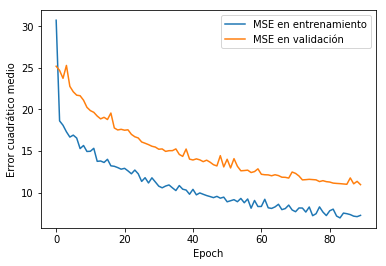

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fd8b1e8d780>
Batch size = 4
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 

<Figure size 432x288 with 0 Axes>

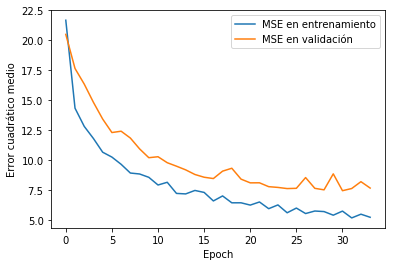

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fd8b1e8d898>
Batch size = 8
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 

89/89 - 12s - loss: 10.2929 - val_loss: 12.9507
Epoch 14/200
89/89 - 12s - loss: 9.7204 - val_loss: 12.2246
Epoch 15/200
89/89 - 12s - loss: 8.8437 - val_loss: 12.6643
Epoch 16/200
89/89 - 12s - loss: 9.7997 - val_loss: 11.6109
Epoch 17/200
89/89 - 12s - loss: 8.8816 - val_loss: 11.3386
Epoch 18/200
89/89 - 12s - loss: 8.5574 - val_loss: 11.5748
Epoch 19/200
89/89 - 12s - loss: 8.9335 - val_loss: 10.8943
Epoch 20/200
89/89 - 12s - loss: 8.3313 - val_loss: 11.3315
Epoch 21/200
89/89 - 12s - loss: 7.6303 - val_loss: 10.4317
Epoch 22/200
89/89 - 12s - loss: 8.4744 - val_loss: 10.7156
Epoch 23/200
89/89 - 12s - loss: 8.4213 - val_loss: 10.1166
Epoch 24/200
89/89 - 12s - loss: 7.6751 - val_loss: 9.9581
Epoch 25/200
89/89 - 12s - loss: 7.5941 - val_loss: 9.8103
Epoch 26/200
89/89 - 12s - loss: 8.0718 - val_loss: 10.0290
Epoch 27/200
89/89 - 12s - loss: 7.1708 - val_loss: 9.7014
Epoch 28/200
89/89 - 12s - loss: 7.5189 - val_loss: 9.4415
Epoch 29/200
89/89 - 12s - loss: 7.2095 - val_loss: 9.93

<Figure size 432x288 with 0 Axes>

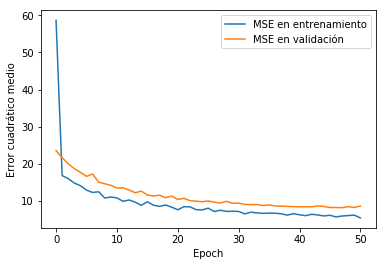

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fd8b1e8d9b0>
Batch size = 16
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None,

44/44 - 11s - loss: 6.0319 - val_loss: 8.8612
Epoch 77/200
44/44 - 11s - loss: 6.1017 - val_loss: 8.8247
Epoch 78/200
44/44 - 11s - loss: 6.6167 - val_loss: 8.7771
Epoch 79/200
44/44 - 11s - loss: 6.4426 - val_loss: 8.8486
Epoch 80/200
44/44 - 11s - loss: 6.4885 - val_loss: 8.7963
Tiempo total transcurrido: 882.9308969974518 seconds
9/9 [==============================] - 2s 215ms/step - loss: 6.4306
test_mse: 6.430636829800076
test_rmse: 2.535870034090879


<Figure size 432x288 with 0 Axes>

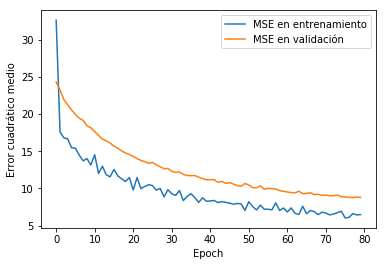

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fd8b1e8dac8>
Batch size = 4
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 272, 204, 

<Figure size 432x288 with 0 Axes>

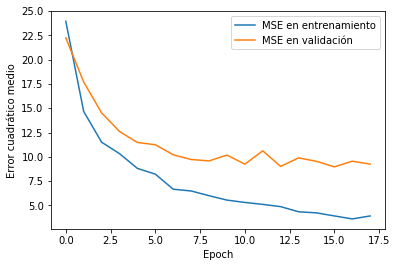

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fd8b1e8dbe0>
Batch size = 8
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 272, 204, 

Epoch 14/200
89/89 - 25s - loss: 5.5293 - val_loss: 9.4375
Epoch 15/200
89/89 - 25s - loss: 5.1348 - val_loss: 9.4909
Epoch 16/200
89/89 - 25s - loss: 4.7368 - val_loss: 9.1364
Epoch 17/200
89/89 - 25s - loss: 4.7874 - val_loss: 9.1231
Epoch 18/200
89/89 - 25s - loss: 4.6533 - val_loss: 9.3680
Epoch 19/200
89/89 - 25s - loss: 4.0738 - val_loss: 9.1401
Epoch 20/200
89/89 - 25s - loss: 4.2162 - val_loss: 9.0983
Epoch 21/200
89/89 - 25s - loss: 4.1100 - val_loss: 11.0918
Tiempo total transcurrido: 527.1657845973969 seconds
19/19 [==============================] - 4s 233ms/step - loss: 8.4668
test_mse: 8.466753005981445
test_rmse: 2.9097685485243403


<Figure size 432x288 with 0 Axes>

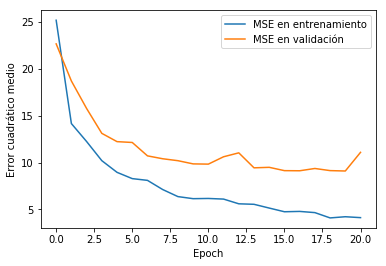

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fd8b1e8dcc0>
Batch size = 16
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 272, 204,

<Figure size 432x288 with 0 Axes>

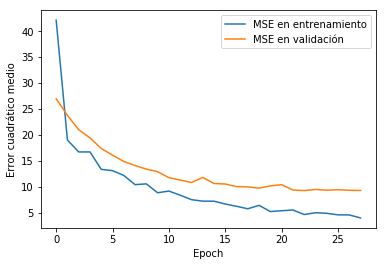

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fd8b1e8dda0>
Batch size = 4
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 181, 136, 

179/179 - 14s - loss: 17.7168 - val_loss: 12.5138
Epoch 2/200
179/179 - 13s - loss: 9.1240 - val_loss: 9.8558
Epoch 3/200
179/179 - 13s - loss: 7.7333 - val_loss: 8.5824
Epoch 4/200
179/179 - 13s - loss: 6.2886 - val_loss: 9.6420
Epoch 5/200
179/179 - 13s - loss: 5.8756 - val_loss: 8.2241
Epoch 6/200
179/179 - 13s - loss: 5.7201 - val_loss: 8.2030
Epoch 7/200
179/179 - 13s - loss: 5.3736 - val_loss: 7.5799
Epoch 8/200
179/179 - 13s - loss: 4.9120 - val_loss: 8.3309
Epoch 9/200
179/179 - 13s - loss: 4.2784 - val_loss: 7.3257
Epoch 10/200
179/179 - 13s - loss: 4.3315 - val_loss: 7.6588
Epoch 11/200
179/179 - 13s - loss: 4.2066 - val_loss: 8.0976
Epoch 12/200
179/179 - 13s - loss: 3.7227 - val_loss: 7.2806
Epoch 13/200
179/179 - 13s - loss: 3.7790 - val_loss: 8.7123
Epoch 14/200
179/179 - 14s - loss: 3.4861 - val_loss: 7.8249
Tiempo total transcurrido: 187.97662138938904 seconds
38/38 [==============================] - 2s 60ms/step - loss: 5.3855
test_mse: 5.38551263119045
test_rmse: 2.32

<Figure size 432x288 with 0 Axes>

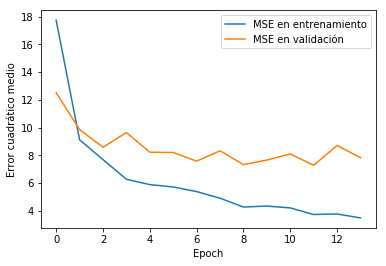

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fd8b1e8de80>
Batch size = 8
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 181, 136, 

Epoch 14/200
89/89 - 12s - loss: 4.2267 - val_loss: 7.2164
Epoch 15/200
89/89 - 12s - loss: 3.8380 - val_loss: 6.8077
Epoch 16/200
89/89 - 12s - loss: 4.2191 - val_loss: 6.8128
Epoch 17/200
89/89 - 12s - loss: 3.6413 - val_loss: 6.8427
Epoch 18/200
89/89 - 12s - loss: 3.5418 - val_loss: 7.0118
Epoch 19/200
89/89 - 12s - loss: 3.5375 - val_loss: 6.8611
Epoch 20/200
89/89 - 12s - loss: 3.5588 - val_loss: 6.7865
Tiempo total transcurrido: 239.3044581413269 seconds
19/19 [==============================] - 2s 111ms/step - loss: 5.4270
test_mse: 5.42698493756746
test_rmse: 2.3295890061483937


<Figure size 432x288 with 0 Axes>

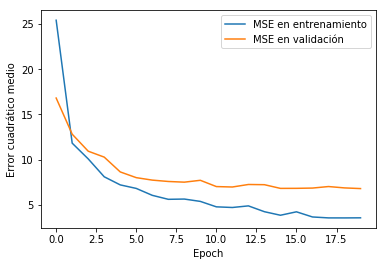

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fd8b1e8df60>
Batch size = 16
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 181, 136,

<Figure size 432x288 with 0 Axes>

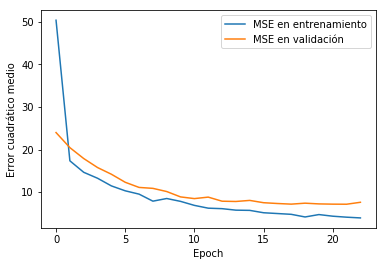

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fd8b1e8db70>
Batch size = 4
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None,

<Figure size 432x288 with 0 Axes>

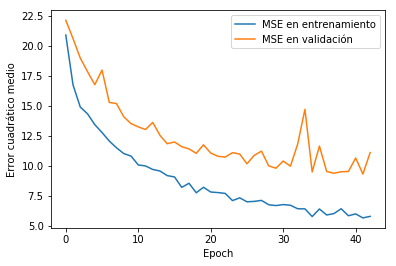

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fd8b1e8d160>
Batch size = 8
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None,

<Figure size 432x288 with 0 Axes>

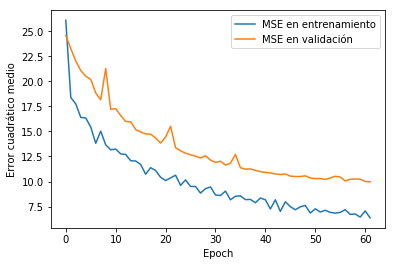

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fd8b1e8f278>
Batch size = 16
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None

Epoch 13/200
179/179 - 13s - loss: 7.8830 - val_loss: 9.4743
Epoch 14/200
179/179 - 13s - loss: 7.2625 - val_loss: 11.0792
Epoch 15/200
179/179 - 13s - loss: 7.0765 - val_loss: 9.3503
Epoch 16/200
179/179 - 13s - loss: 6.8239 - val_loss: 10.9858
Epoch 17/200
179/179 - 13s - loss: 6.8547 - val_loss: 8.8188
Epoch 18/200
179/179 - 13s - loss: 6.9707 - val_loss: 8.6427
Epoch 19/200
179/179 - 13s - loss: 6.9483 - val_loss: 8.6823
Epoch 20/200
179/179 - 13s - loss: 6.3155 - val_loss: 11.1859
Epoch 21/200
179/179 - 13s - loss: 6.3653 - val_loss: 8.3997
Epoch 22/200
179/179 - 13s - loss: 6.3934 - val_loss: 8.8665
Epoch 23/200
179/179 - 13s - loss: 6.1583 - val_loss: 8.6513
Epoch 24/200
179/179 - 13s - loss: 5.8196 - val_loss: 8.2031
Epoch 25/200
179/179 - 13s - loss: 5.8763 - val_loss: 8.2717
Epoch 26/200
179/179 - 13s - loss: 6.1085 - val_loss: 8.3526
Epoch 27/200
179/179 - 13s - loss: 5.8012 - val_loss: 8.4808
Epoch 28/200
179/179 - 13s - loss: 5.9616 - val_loss: 8.0716
Epoch 29/200
179/179 

<Figure size 432x288 with 0 Axes>

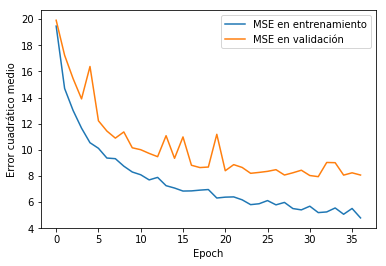

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fd8b1e8f4a8>
Batch size = 8
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None,

<Figure size 432x288 with 0 Axes>

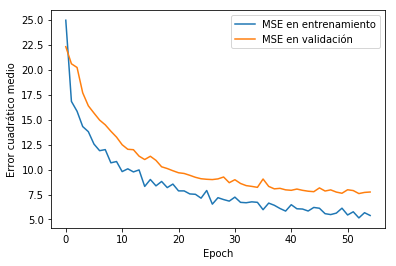

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fd8b1e8f5c0>
Batch size = 16
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:140: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



<Figure size 432x288 with 0 Axes>

In [10]:
summ_results_tf_vgg16, histories_tf_vgg16, test_losses_tf_vgg16, times_tf_vgg16, errors_tf_vgg16 = gridSearch_tf(model_arqs_transf_learn, max_epochs, patience, min_delta, train_data, imgs_path, x_col, y_col, "TF_VGG16", datagen)

summ_results_tf_vgg16["Arq"] = "TF_VGG16"
summ_results_tf_vgg16.to_csv("summ_results_tf_vgg16.csv", index=False)

W0609 16:04:35.969864 139871939544832 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f35eb8854e0>
Batch size = 16
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None

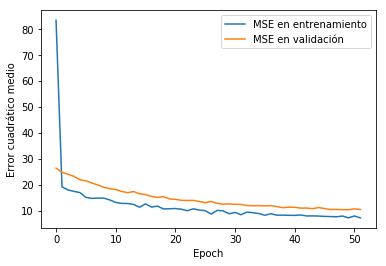

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:140: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f35eb885198>
Batch size = 16
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None

Epoch 76/200
44/44 - 24s - loss: 7.7499 - val_loss: 11.6983
Epoch 77/200
44/44 - 24s - loss: 7.2775 - val_loss: 11.7938
Epoch 78/200
44/44 - 24s - loss: 8.1144 - val_loss: 11.6131
Epoch 79/200
44/44 - 24s - loss: 6.9193 - val_loss: 11.5619
Epoch 80/200
44/44 - 24s - loss: 7.5810 - val_loss: 11.8109
Epoch 81/200
44/44 - 24s - loss: 7.4447 - val_loss: 12.1753
Epoch 82/200
44/44 - 24s - loss: 7.4529 - val_loss: 12.2261
Epoch 83/200
44/44 - 24s - loss: 7.3689 - val_loss: 11.4300
Epoch 84/200
44/44 - 24s - loss: 7.5022 - val_loss: 11.3951
Epoch 85/200
44/44 - 24s - loss: 7.1976 - val_loss: 11.4288
Epoch 86/200
44/44 - 24s - loss: 6.9882 - val_loss: 11.3260
Epoch 87/200
44/44 - 24s - loss: 7.3391 - val_loss: 11.2768
Epoch 88/200
44/44 - 24s - loss: 6.9194 - val_loss: 11.2552
Epoch 89/200
44/44 - 24s - loss: 7.4620 - val_loss: 11.2423
Epoch 90/200
44/44 - 24s - loss: 6.9478 - val_loss: 11.1810
Epoch 91/200
44/44 - 24s - loss: 7.0622 - val_loss: 11.1928
Epoch 92/200
44/44 - 24s - loss: 7.0959 

<Figure size 432x288 with 0 Axes>

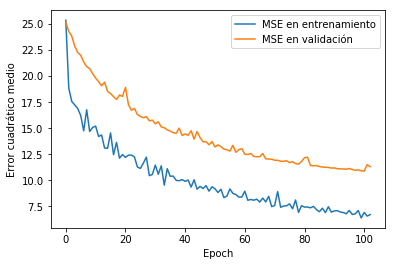

<Figure size 432x288 with 0 Axes>

In [10]:
# los dos modelos con un batch size más grande (16) y un learning rate más pequeño (0.001) 
# han fallado por falta de recursos (la GPU no ha borrado memoria bien)
# Los ejecutamos por separado y unimos los resultados manualmente con el anterior csv
summ_results_tf_vgg16_1, histories_tf_vgg16_1, test_losses_tf_vgg16_1, times_tf_vgg16_1, errors_tf_vgg16_1 = gridSearch_tf([model_arqs_transf_learn[-1]], max_epochs, patience, min_delta, train_data, imgs_path, x_col, y_col, "TF_VGG16", datagen)
summ_results_tf_vgg16_2, histories_tf_vgg16_2, test_losses_tf_vgg16_2, times_tf_vgg16_2, errors_tf_vgg16_2 = gridSearch_tf([model_arqs_transf_learn[-4]], max_epochs, patience, min_delta, train_data, imgs_path, x_col, y_col, "TF_VGG16", datagen)

summ_results_tf_vgg16_1["Arq"] = "TF_VGG16"
summ_results_tf_vgg16_1.to_csv("summ_results_tf_vgg16_1.csv", index=False)

summ_results_tf_vgg16_2["Arq"] = "TF_VGG16"
summ_results_tf_vgg16_2.to_csv("summ_results_tf_vgg16_2.csv", index=False)

<a id='2_2_fine_tuning'></a>
## 2.2 Fine-tuning

Ahora, dejamos que el modelo entrene también los parámetros pre-entrenados. El grid search en este caso es más pequeño debido a tener una red compleja. El learning rate es más pequeño, ya que se supone que el punto desde el que se parte en el entrenamiento es ya un buen resultado.

In [10]:
max_epochs = 200
patience = 5
min_delta = 0.1

Base_models = ["VGG16"]
LearnRates = [1e-2, 1e-3]
Optimizers = ["Adam", "SGD"]
Batches = [4]   
Sizes = [[int(img_width/i), int(img_height/i)] for i in [6, 9]]

model_arqs_fine_tuning = []

# Arquitectura base
for learnRate in LearnRates:
    for optimizer in Optimizers:
        for size in Sizes:
            for batch in Batches:
                for base_model in Base_models:
                    model_arq = ModelTransfLearnClass()
                    model_arq.Batch = batch
                    model_arq.optim_upd(optimizer)
                    model_arq.target_width = size[0]
                    model_arq.target_height = size[1]
                    model_arq.LearnRate = learnRate
                    model_arq.trainable = True
                    model_arqs_fine_tuning.append(model_arq)

W0609 19:05:45.884809 139884495435520 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f38d7e77160>
Batch size = 4
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 272, 204, 1

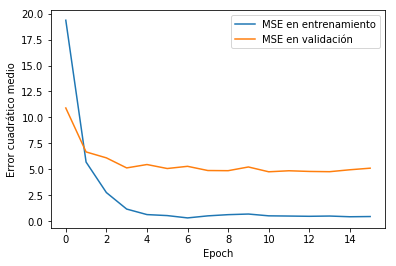

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f38d7e77860>
Batch size = 4
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 181, 136, 1

Epoch 14/200
179/179 - 33s - loss: 0.4236 - val_loss: 5.4389
Epoch 15/200
179/179 - 33s - loss: 0.3373 - val_loss: 5.2111
Tiempo total transcurrido: 499.5333683490753 seconds
38/38 [==============================] - 2s 61ms/step - loss: 3.6017
test_mse: 3.6017020383947775
test_rmse: 1.8978150695983993


<Figure size 432x288 with 0 Axes>

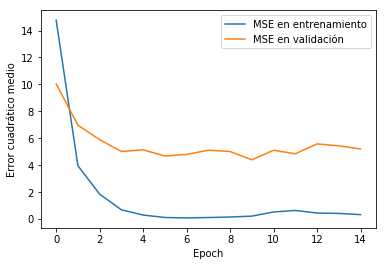

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f38d7e77940>
Batch size = 4
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 

<Figure size 432x288 with 0 Axes>

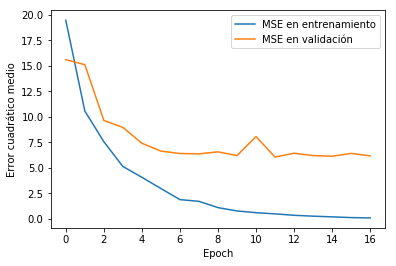

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f38d7e77a20>
Batch size = 4
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 

<Figure size 432x288 with 0 Axes>

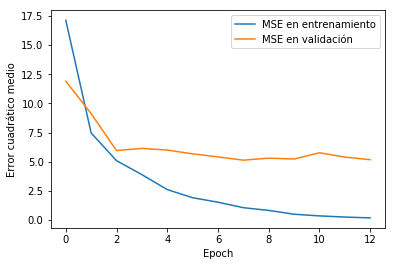

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f38d7e77b38>
Batch size = 4
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 272, 204, 

<Figure size 432x288 with 0 Axes>

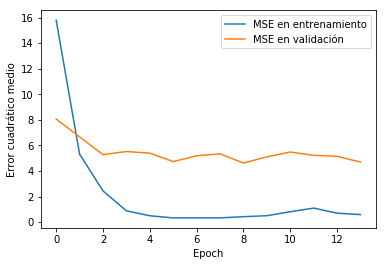

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f38d7e77c50>
Batch size = 4
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 181, 136, 

<Figure size 432x288 with 0 Axes>

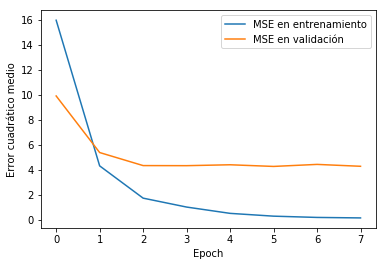

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f38d7e77d30>
Batch size = 4
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None,

<Figure size 432x288 with 0 Axes>

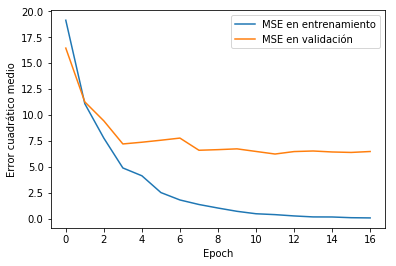

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f38d7e77e10>
Batch size = 4
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None,

<Figure size 432x288 with 0 Axes>

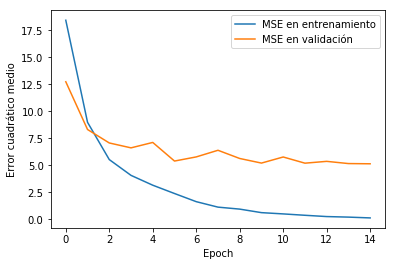

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:140: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



<Figure size 432x288 with 0 Axes>

In [11]:
summ_results_fn_vgg16, histories_fn_vgg16, test_losses_fn_vgg16, times_fn_vgg16, errors_fn_vgg16 = gridSearch_tf(model_arqs_fine_tuning, max_epochs, patience, min_delta, train_data, imgs_path, x_col, y_col, "FN_VGG16", datagen)

summ_results_fn_vgg16["Arq"] = "FN_VGG16"
summ_results_fn_vgg16.to_csv("summ_results_fn_vgg16.csv", index=False)

<a id='3_data_augmentation'></a>
# 3. Data augmentation

En esta aproximación, entrenaremos de nuevo los modelos con mejores resultados en entrenamiento del modelo sencillo y el modelo con fine-tuning con VGG16. La idea es mejorar los modelos que tenían overfitting usando la técnica de regularización data augmentation.

Definimos el generador de imágenes.

In [33]:
# Generamos los batches con los datos para las tres particiones
datagen_augm = ImageDataGenerator(rescale=1./255, 
                            rotation_range=30.0,
                            horizontal_flip=True,
                            vertical_flip=True,
                            brightness_range=(0.1,0.9), # de hecho, los autores del dataset dicen que las condiciones de luz cambian
                            shear_range=10.0, # un poco de deformación
                            channel_shift_range=150.0
                                 )

Mostramos varios ejemplos del resultado en una imagen original de usar data augmentation. Para ello, definimos una función que genera 8 imágenes transformadas a partir de una original.

In [23]:
def generate_plot_pics(datagen,orig_img):
    dir_augmented_data = "./TrabajoDeepLearning/DL_UNIMIB2016/UNIMIB2016/preview"

    # transformamos la imagen original a array
    x = img_to_array(orig_img)
    x = x.reshape((1,) + x.shape)
    
    # generamos 8 imágenes tranformadas
    i = 0
    Nplot = 8
    for batch in datagen.flow(x,batch_size=1,
                          save_to_dir=dir_augmented_data,
                          save_prefix="pic",
                          save_format='jpeg'):
        i += 1
        if i > Nplot - 1: 
            break

    # Mostramos las imágenes generadas
    fig = plt.figure(figsize=(8, 6))
    fig.subplots_adjust(hspace=0.02,wspace=0.01,
                    left=0,right=1,bottom=0, top=1)

    # Mostramos la imagen original
    ax = fig.add_subplot(3, 3, 1,xticks=[],yticks=[])        
    ax.imshow(orig_img)
    ax.set_title("original")

    i = 2
    for imgnm in os.listdir(dir_augmented_data):
        ax = fig.add_subplot(3, 3, i,xticks=[],yticks=[]) 
        img = load_img(dir_augmented_data + "/" + imgnm)
        ax.imshow(img)
        i += 1
    plt.show()

Generamos entonces las imágenes.

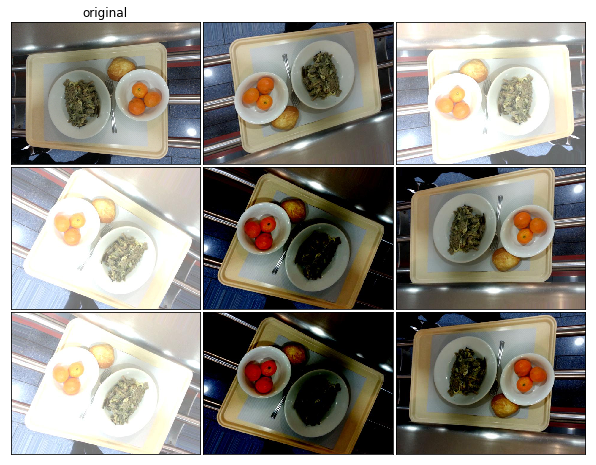

In [48]:
orig_img = load_img('./TrabajoDeepLearning/DL_UNIMIB2016/UNIMIB2016/images/20151127_121306.jpg')
generate_plot_pics(datagen_augm,orig_img)

<a id='3_1_modelo_sencillo'></a>
## 3.1 Modelo sencillo

Entrenamos entonces los modelos con menor MSE en entrenamiento de la primera aproximación.

Al tener data augmentation, el entrenamiento será más errático y más lento, por lo que aumentamos el valor de patience para el early stopping.

In [13]:
max_epochs = 200
patience = 7
min_delta = 0.1

<a id='3_1_1_base'></a>
### 3.1.1 Base

Definimos entonces los modelos basándonos en los anteriores resultados. Empezamos con la arquitectura con solo dos bloques convolucionales ("base").

In [13]:
model_arqs_da_base = []

for i in range(0,6):
    model_arq = ModelClass()
    model_arq.Batch = summ_results_base.sort_values(by="Train_loss").iloc[i].Batch
    model_arq.optim_upd("Adam" if "Adam" in str(summ_results_base.sort_values(by="Train_loss").iloc[i].Optimizer) else "SGD")
    model_arq.target_width = summ_results_base.sort_values(by="Train_loss").iloc[i].Width
    model_arq.target_height = summ_results_base.sort_values(by="Train_loss").iloc[i].Height
    model_arq.LearnRate = summ_results_base.sort_values(by="Train_loss").iloc[i].LearnRate
    
    model_arqs_da_base.append(model_arq)

Entrenamos el modelo sencillo con los hiper-parámetros escogidos.

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f4a874c69e8>
Batch size = 8
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248 

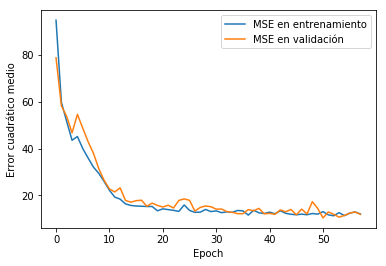

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f4a874c6f60>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248 

<Figure size 432x288 with 0 Axes>

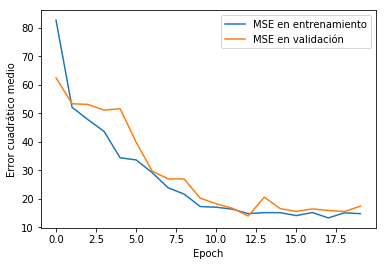

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f4a874c62e8>
Batch size = 16
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248  

<Figure size 432x288 with 0 Axes>

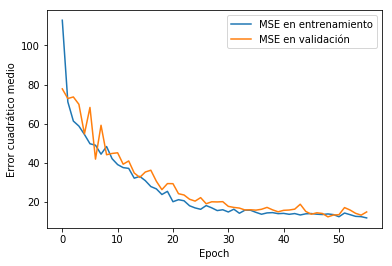

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f4a874c6cc0>
Batch size = 8
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248  

<Figure size 432x288 with 0 Axes>

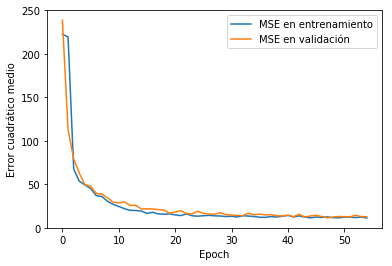

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f4a874c6f98>
Batch size = 8
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)        9248  

<Figure size 432x288 with 0 Axes>

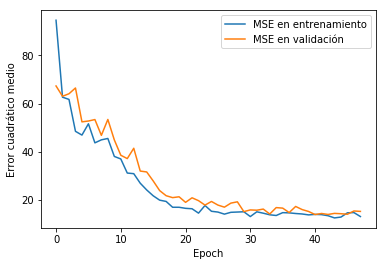

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f4a86c343c8>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248  

<Figure size 432x288 with 0 Axes>

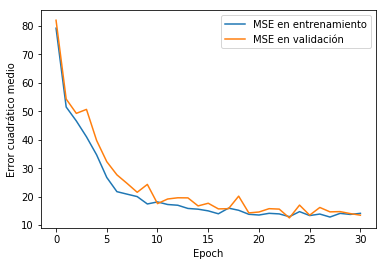

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



<Figure size 432x288 with 0 Axes>

In [14]:
summ_results_da_base, histories_da_base, test_losses_da_base, times_da_base, errors_da_base = gridSearch(model_arqs_da_base, max_epochs, patience, min_delta, train_data, imgs_path, x_col, y_col, "DA_Base", datagen_augm)
summ_results_da_base["Arq"] = "DA_Base"

# Guardamos los resultados
summ_results_da_base.to_csv("summ_results_da_base.csv", index=False)

Al tener que transformar las imágenes en cada epoch, el tiempo de cómputo aumenta de 8s/epoch a 36s/epoch.

<a id='3_1_2_extra'></a>
### 3.1.2 Extra

Procedemos de manera ánaloga con la arquitectura con tres bloques convolucionales iguales ("extra").

In [13]:
summ_results_da_extra = []

for i in range(0,6):
    model_arq = ModelClass()
    model_arq.Batch = summ_results_extra.sort_values(by="Train_loss").iloc[i].Batch
    model_arq.optim_upd("Adam" if "Adam" in str(summ_results_extra.sort_values(by="Train_loss").iloc[i].Optimizer) else "SGD")
    model_arq.target_width = summ_results_extra.sort_values(by="Train_loss").iloc[i].Width
    model_arq.target_height = summ_results_extra.sort_values(by="Train_loss").iloc[i].Height
    model_arq.LearnRate = summ_results_extra.sort_values(by="Train_loss").iloc[i].LearnRate
    
    summ_results_da_extra.append(model_arq)

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f3d3376bb00>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248   

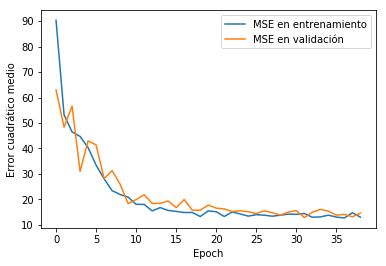

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f3d337e15f8>
Batch size = 16
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248 

<Figure size 432x288 with 0 Axes>

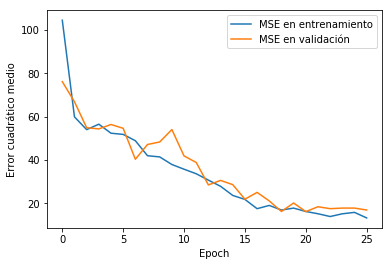

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f3d337a57f0>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248 

<Figure size 432x288 with 0 Axes>

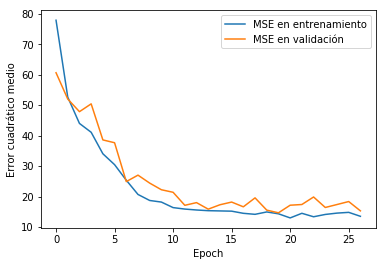

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f3d337a5828>
Batch size = 16
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248  

<Figure size 432x288 with 0 Axes>

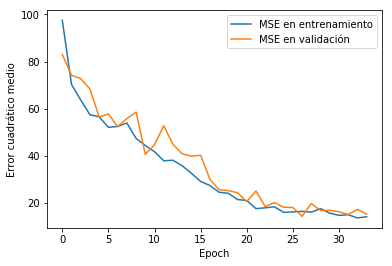

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f3d32e250f0>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248  

<Figure size 432x288 with 0 Axes>

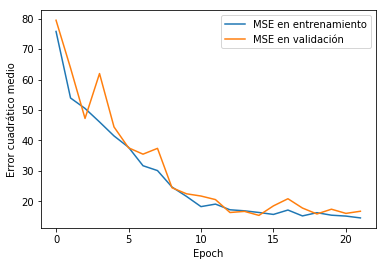

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f3d32e25320>
Batch size = 8
Width = 362, height = 272
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 270, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 268, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 67, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 65, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 63, 32)        9248 

<Figure size 432x288 with 0 Axes>

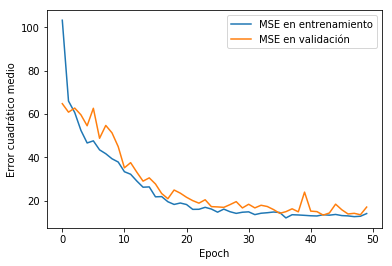

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



<Figure size 432x288 with 0 Axes>

In [15]:
summ_results_da_extra, histories_da_extra, test_losses_da_extra, times_da_extra, errors_da_extra = gridSearch(summ_results_da_extra, max_epochs, patience, min_delta, train_data, imgs_path, x_col, y_col, "DA_Extra", datagen_augm)
summ_results_da_extra["Arq"] = "DA_Extra"

# Guardamos los resultados
summ_results_da_extra.to_csv("summ_results_da_extra.csv", index=False)

<a id='3_1_3_extra_filt'></a>
### 3.1.3 Extra_filt

Hacemos lo mismo con la arquitectura con tres bloques convolucionales con número de filtros creciente ("extra_filt").

In [11]:
summ_results_da_extra_filt = []

for i in range(0,6):
    model_arq = ModelClass()
    model_arq.Batch = summ_results_extra_filt.sort_values(by="Train_loss").iloc[i].Batch
    model_arq.optim_upd("Adam" if "Adam" in str(summ_results_extra_filt.sort_values(by="Train_loss").iloc[i].Optimizer) else "SGD")
    model_arq.target_width = summ_results_extra_filt.sort_values(by="Train_loss").iloc[i].Width
    model_arq.target_height = summ_results_extra_filt.sort_values(by="Train_loss").iloc[i].Height
    model_arq.LearnRate = summ_results_extra_filt.sort_values(by="Train_loss").iloc[i].LearnRate
    
    summ_results_da_extra_filt.append(model_arq)

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f05b99c97b8>
Batch size = 8
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248 

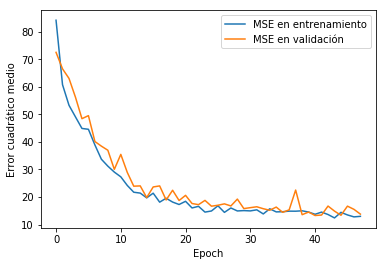

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f05b99c9630>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248  

<Figure size 432x288 with 0 Axes>

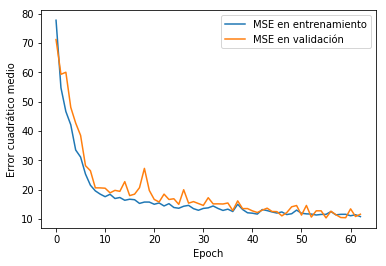

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f05b99c9c88>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248   

<Figure size 432x288 with 0 Axes>

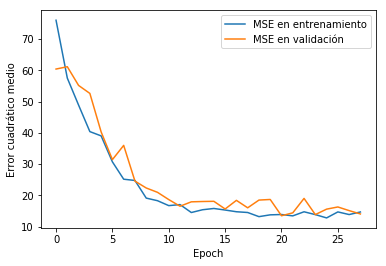

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f05b99c9b38>
Batch size = 8
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248  

<Figure size 432x288 with 0 Axes>

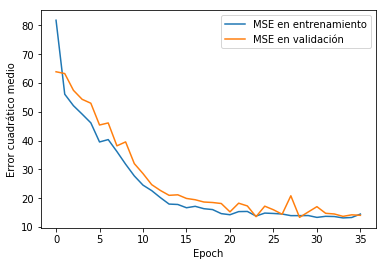

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.1
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f05b99c9b70>
Batch size = 8
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32)       9248   

<Figure size 432x288 with 0 Axes>

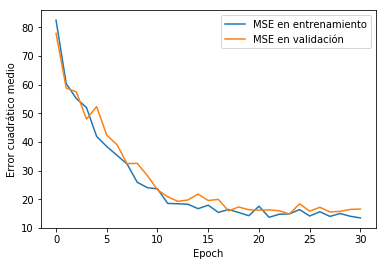

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f05b99c9eb8>
Batch size = 4
Width = 544, height = 408
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 542, 406, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 404, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 133, 99, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 131, 97, 32) 

<Figure size 432x288 with 0 Axes>

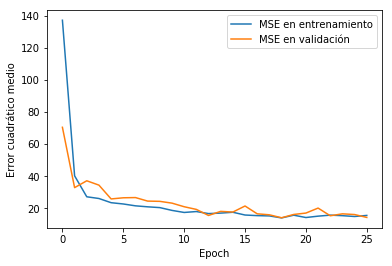

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



<Figure size 432x288 with 0 Axes>

In [14]:
summ_results_da_extra_filt, histories_da_extra_filt, test_losses_da_extra_filt, times_da_extra_filt, errors_da_extra_filt = gridSearch(summ_results_da_extra_filt, max_epochs, patience, min_delta, train_data, imgs_path, x_col, y_col, "DA_Extra_filt", datagen_augm)
summ_results_da_extra_filt["Arq"] = "DA_Extra_filt"

# Guardamos los resultados
summ_results_da_extra_filt.to_csv("summ_results_da_extra_filt.csv", index=False)

<a id='3_2_fine_tuning'></a>
## 3.2 Fine-tuning
Para terminar, usaremos data augmentation para entrenar todos los parámetros de la red VGG16.

In [11]:
Base_models = ["VGG16"]
LearnRates = [1e-2, 1e-3]
Optimizers = ["Adam", "SGD"]
Batches = [4]   
Sizes = [[int(img_width/i), int(img_height/i)] for i in [6, 9]]

model_arqs_data_augm_fine_tuning = []

# Arquitectura base
for learnRate in LearnRates:
    for optimizer in Optimizers:
        for size in Sizes:
            for batch in Batches:
                for base_model in Base_models:
                    model_arq = ModelTransfLearnClass()
                    model_arq.Batch = batch
                    model_arq.optim_upd(optimizer)
                    model_arq.target_width = size[0]
                    model_arq.target_height = size[1]
                    model_arq.LearnRate = learnRate
                    model_arq.trainable = True
                    model_arqs_data_augm_fine_tuning.append(model_arq)

W0609 22:02:17.065077 140488644298496 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc580f9fb00>
Batch size = 4
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 272, 204, 1

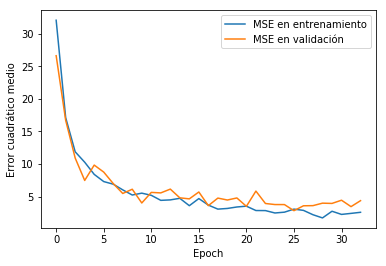

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc580f67128>
Batch size = 4
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 181, 136, 1

179/179 - 34s - loss: 3.4309 - val_loss: 5.9367
Epoch 12/200
179/179 - 34s - loss: 3.9279 - val_loss: 6.5930
Epoch 13/200
179/179 - 34s - loss: 3.7506 - val_loss: 4.8727
Epoch 14/200
179/179 - 34s - loss: 3.4042 - val_loss: 4.9430
Epoch 15/200
179/179 - 34s - loss: 3.1184 - val_loss: 5.1057
Epoch 16/200
179/179 - 34s - loss: 2.8127 - val_loss: 4.1842
Epoch 17/200
179/179 - 34s - loss: 2.6003 - val_loss: 3.8307
Epoch 18/200
179/179 - 34s - loss: 2.5130 - val_loss: 4.6823
Epoch 19/200
179/179 - 34s - loss: 2.3807 - val_loss: 3.6665
Epoch 20/200
179/179 - 34s - loss: 2.8981 - val_loss: 3.5369
Epoch 21/200
179/179 - 34s - loss: 2.1442 - val_loss: 3.6124
Epoch 22/200
179/179 - 34s - loss: 2.5195 - val_loss: 3.6192
Epoch 23/200
179/179 - 34s - loss: 2.4591 - val_loss: 3.1327
Epoch 24/200
179/179 - 34s - loss: 2.3481 - val_loss: 3.1829
Epoch 25/200
179/179 - 34s - loss: 1.7948 - val_loss: 3.4646
Epoch 26/200
179/179 - 34s - loss: 2.1197 - val_loss: 3.5420
Epoch 27/200
179/179 - 34s - loss: 1.

<Figure size 432x288 with 0 Axes>

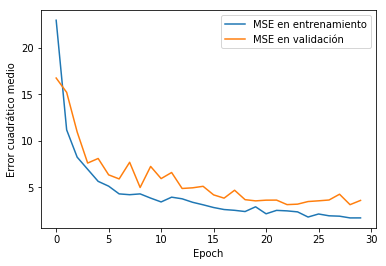

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fc580f67208>
Batch size = 4
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 

Epoch 11/200
179/179 - 71s - loss: 7.9714 - val_loss: 10.5350
Epoch 12/200
179/179 - 71s - loss: 7.6742 - val_loss: 9.1970
Epoch 13/200
179/179 - 71s - loss: 6.8637 - val_loss: 8.8899
Epoch 14/200
179/179 - 71s - loss: 6.5480 - val_loss: 5.6162
Epoch 15/200
179/179 - 71s - loss: 7.0475 - val_loss: 8.1921
Epoch 16/200
179/179 - 71s - loss: 6.7170 - val_loss: 7.7775
Epoch 17/200
179/179 - 71s - loss: 6.3337 - val_loss: 6.7270
Epoch 18/200
179/179 - 71s - loss: 5.8778 - val_loss: 6.2947
Epoch 19/200
179/179 - 71s - loss: 5.2774 - val_loss: 5.9262
Epoch 20/200
179/179 - 71s - loss: 5.8790 - val_loss: 7.2732
Epoch 21/200
179/179 - 71s - loss: 5.1814 - val_loss: 5.7468
Tiempo total transcurrido: 1487.5525987148285 seconds
38/38 [==============================] - 7s 174ms/step - loss: 5.6422
test_mse: 5.642155816680507
test_rmse: 2.375322255333054


<Figure size 432x288 with 0 Axes>

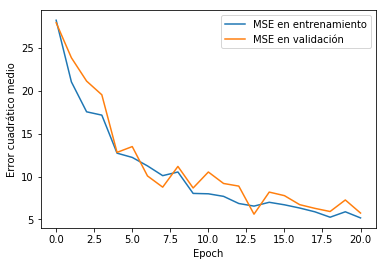

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.01
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fc580f67080>
Batch size = 4
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 

<Figure size 432x288 with 0 Axes>

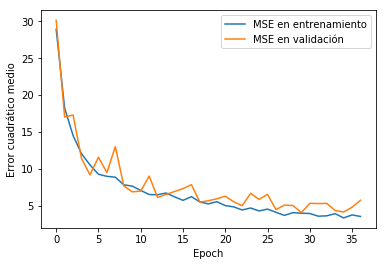

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc580f67240>
Batch size = 4
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 272, 204, 

<Figure size 432x288 with 0 Axes>

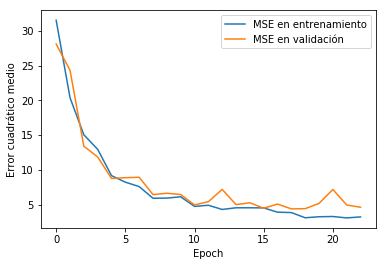

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fc580f67358>
Batch size = 4
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 181, 136, 

<Figure size 432x288 with 0 Axes>

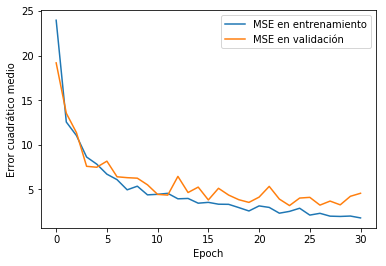

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fc580f674a8>
Batch size = 4
Base model = VGG16
Width = 544, height = 408
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 408, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 544, 408, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 544, 408, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 272, 204, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None,

<Figure size 432x288 with 0 Axes>

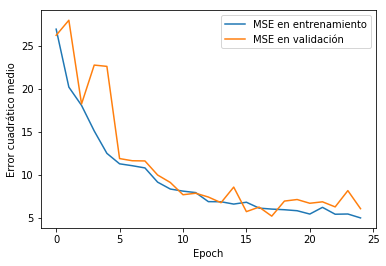

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 0.001
Optimizer = <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7fc580f674e0>
Batch size = 4
Base model = VGG16
Width = 362, height = 272
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 362, 272, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 362, 272, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 362, 272, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 181, 136, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None,

<Figure size 432x288 with 0 Axes>

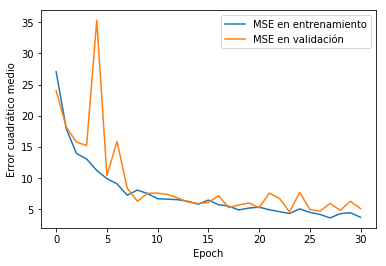

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:140: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



<Figure size 432x288 with 0 Axes>

In [12]:
summ_results_data_augm_fn_vgg16, histories_data_augm_fn_vgg16, test_losses_data_augm_fn_vgg16, times_data_augm_fn_vgg16, errors_data_augm_fn_vgg16 = gridSearch_tf(model_arqs_data_augm_fine_tuning, max_epochs, patience, min_delta, train_data, imgs_path, x_col, y_col, "DA_FN_VGG16", datagen_augm)

summ_results_data_augm_fn_vgg16["Arq"] = "DA_FN_VGG16"
summ_results_data_augm_fn_vgg16.to_csv("summ_results_data_augm_fn_vgg16.csv", index=False)